In [1]:
# Manipulação e Tratamento de dados
import openpyxl
import pandas as pd
import numpy as np
from numpy import NaN
import duckdb as dd

#ignorando Warning inuteis
import warnings 
from pandas.errors import SettingWithCopyWarning
warnings.simplefilter(action="ignore", category=SettingWithCopyWarning)
warnings.filterwarnings(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

#definindo quantidade de linhas e colunas visiveis
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 500)

In [2]:
# Graficos ############################
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.dates as mdates

plt.style.use('dark_background')
plt.style.use('seaborn-v0_8-whitegrid')

import seaborn as sns
custom_palette = sns.color_palette("bright")
sns.palplot(custom_palette)
sns.set_palette("bright")
sns.set_style('whitegrid') #cor da grade(fundo)

# Definindo o estilo de fonte e tema
import matplotlib.font_manager as fm #para alterar as fontes dos graficos
fonte = fm.FontProperties(family="Calibri", style="italic")
%matplotlib inline

In [3]:
# Copia e cola
import pyperclip

# Manipulação de Strings
from unidecode import unidecode #unidecode(string)
import re # Regex

# Controle de Erros
import traceback

# Manipualação de datas
from datetime import *

In [4]:
# Carregando minhas funções de analise de dados e criação de modelos
import requests

url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + 'funcoes_estatisticas' + ".py"
print(url); response = requests.get(url); code = response.text; exec(code)

# Função para avaliação de modelos exibindo metricas de avaliação
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, RocCurveDisplay
url = "https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/" + 'ML_supervised_learning' + ".py"
print(url); response = requests.get(url); code = response.text; exec(code)

def aval_modelo_corte_tabela(y_true, y_probs_positivas, beta = 1.5, pontos_de_corte = np.arange(10, 100, 10)):
    y_probs_positivas = np.array(y_probs_positivas)
    # Inicializando um DataFrame para armazenar as métricas
    fd = pd.DataFrame(columns=['threshold', 'tn', 'fp', 'fn', 'tp'])

    # Loop pelos pontos de corte
    for threshold in pontos_de_corte:
        previsoes_personalizadas = (y_probs_positivas >= threshold).astype(int)

        # Calculando os valores de tn, fp, fn, tp
        tn = len(np.where((previsoes_personalizadas == 0) & (y_true == 0))[0])
        fp = len(np.where((previsoes_personalizadas == 1) & (y_true == 0))[0])
        
        fn = len(np.where((previsoes_personalizadas == 0) & (y_true == 1))[0])
        tp = len(np.where((previsoes_personalizadas == 1) & (y_true == 1))[0])

        # Adicionando os resultados ao DataFrame 'fd'
        fd = pd.concat([fd, pd.DataFrame([[threshold, tn, fp, fn, tp]], columns=fd.columns)])

    # Substituir valores NaN por 0
    fd.fillna(0, inplace=True)
    fd.reset_index(drop=True, inplace=True)
    ######################################################################################

    # Inicializar as colunas das métricas com NaN
    metricas_de_aval = ['acuracia', 'precisao', 'sensibilidade', 'especificidade', 'f1', #'fb_score',
                        # 'valor_pre_posi', 'valor_pre_neg', 'taxa_falsos_positivos', 'taxa_falsos_negativos',
                        'custo_who','fraude_evitada','delta']#,
                        # 'fdr', 'fo_r', 'indice_youden', 'coef_matthews']
    fd[metricas_de_aval] = 0

    # Loop para calcular as métricas em cada linha
    for i in range(len(fd)):
        # Acurácia
        if (fd['tn'][i] + fd['fp'][i] + fd['fn'][i] + fd['tp'][i]) != 0:
            fd['acuracia'][i] = (fd['tp'][i] + fd['tn'][i]) / (fd['tn'][i] + fd['fp'][i] + fd['fn'][i] + fd['tp'][i])

        # Precisão
        if (fd['tp'][i] + fd['fp'][i]) != 0:
            fd['precisao'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fp'][i])

        # Sensibilidade (Recall)
        if (fd['tp'][i] + fd['fn'][i]) != 0:
            fd['sensibilidade'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fn'][i])

        # Especificidade
        if (fd['tn'][i] + fd['fp'][i]) != 0:
            fd['especificidade'][i] = fd['tn'][i] / (fd['tn'][i] + fd['fp'][i])

        # F1-Score
        if (fd['precisao'][i] + fd['sensibilidade'][i]) != 0:
            fd['f1'][i] = 2 * (fd['precisao'][i] * fd['sensibilidade'][i]) / (fd['precisao'][i] + fd['sensibilidade'][i])

        # # Valor Preditivo Positivo
        # if (fd['tp'][i] + fd['fp'][i]) != 0:
        #     fd['valor_pre_posi'][i] = fd['tp'][i] / (fd['tp'][i] + fd['fp'][i])

        # # Valor Preditivo Negativo
        # if (fd['tn'][i] + fd['fn'][i]) != 0:
        #     fd['valor_pre_neg'][i] = fd['tn'][i] / (fd['tn'][i] + fd['fn'][i])

        # # Taxa de Falsos Positivos
        # fd['taxa_falsos_positivos'][i] = 1 - fd['especificidade'][i]

        # # Taxa de Falsos Negativos
        # fd['taxa_falsos_negativos'][i] = 1 - fd['sensibilidade'][i]

        fd['custo_who'][i] = (fd['tp'][i] + fd['fp'][i]) * 10.0
        fd['fraude_evitada'][i] = fd['tp'][i] * 8000
        fd['delta'][i] = fd['fraude_evitada'][i] - fd['custo_who'][i]

        # # False Discovery Rate (FDR)
        # if (fd['tp'][i] + fd['fp'][i]) != 0:
        #     fd['fdr'][i] = fd['fp'][i] / (fd['tp'][i] + fd['fp'][i])

        # # False Omission Rate (FOR)
        # if (fd['tn'][i] + fd['fn'][i]) != 0:
        #     fd['fo_r'][i] = fd['fn'][i] / (fd['tn'][i] + fd['fn'][i])

        # # Índice de Youden
        # fd['indice_youden'][i] = fd['sensibilidade'][i] + fd['especificidade'][i] - 1

        # try:
        #     # Coeficiente de Matthews (MCC)
        #     denom_matthews = (fd['tp'][i]+fd['fp'][i])*(fd['tp'][i]+fd['fn'][i])*(fd['tn'][i]+fd['fp'][i])*(fd['tn'][i]+fd['fn'][i])
        #     if denom_matthews != 0:
        #         fd['coef_matthews'][i] = (fd['tp'][i]*fd['tn'][i] - fd['fp'][i]*fd['fn'][i]) / np.sqrt(denom_matthews)
        # except:
        #     fd['coef_matthews'][i] = np.nan

        # # F-beta Score
        # denom_fb_score = (beta**2 * fd['valor_pre_posi'][i]) + fd['sensibilidade'][i]
        # if denom_fb_score != 0:
        #     fd['fb_score'][i] = (1 + beta**2) * (fd['valor_pre_posi'][i] * fd['sensibilidade'][i]) / denom_fb_score

    fd[metricas_de_aval] = fd[metricas_de_aval].round(3)
    return fd

print('TUDO OK')

https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/funcoes_estatisticas.py
https://raw.githubusercontent.com/GabrielGabes/functions_gsa/main/ML_supervised_learning.py
TUDO OK


In [5]:
def tabela_cont(df, linha, coluna):
    a = df.groupby([linha, coluna]).size().unstack()
    for i in a.columns:
        a[i].fillna(0, inplace = True)
        a[i] = a[i].apply(lambda x: int(x))
    return a

def count_table_percent(df, linha, coluna, opcao):
    result = tabela_cont(df, linha, coluna)
    if opcao == 'Linha':
        return round(result.div(result.sum(axis=1), axis=0) * 100, 2)
    elif opcao == 'Coluna':
        return round(result.div(result.sum(), axis=1) * 100, 2)
    else:
        return 'Opção invalida'

# Dados

### Dataframe Principal

In [6]:
pasta = 'K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/MODELAGEM/01-Modelagem Estatística/Sandbox/Gabriel/ATIVACAO_DE_BENEFICIO/Treinamento/dados_treinamento_202504/'
df = pd.read_csv(pasta + 'dados_query.csv', sep=';', encoding='ISO-8859-1',
                 dtype={
                     'COD_STATUS': str,
                     'COD_BENEFICIO': str,
                     'COD_SOLICBENEFICIO': str,
                     'NUM_BENEFICIO': str,
                     'NUM_CPF': str,
                     'COD_LOJA_ATIVACAO': str,
                     'COD_LOJA_OFICIAL': str,
                     'COMPARA_NASC': str,
                     'TELEFONE_COMPARTILHADO': str,
                     'TPO_DOCUMENTO': str,
                     'SEQ_ORGAOPAGADOR': str,
                     'NUM_LOTEPREGAO': str
                     }).drop('RN', axis=1)

##############################################################################################
print(df.shape)
df = df.drop_duplicates().reset_index(drop=True)
df['indexx'] = df.index
display(df.sample(3))
print(df.shape)

##############################################################################################
df.columns = df.columns.map(lambda x: unidecode(x).upper().strip().replace(' ','_'))
df['Y'] = 0

print(df.columns)

(2208221, 42)


,COD_STATUS,DTH_INCLUSAO,COD_BENEFICIO,COD_SOLICBENEFICIO,NUM_BENEFICIO,NUM_CPF,NOM_ESPECIEBENEFICIO,TIPO_BENEFICIO,DTA_INI_SOLICITACAO,DTAHRA_INI_SOLICITACAO,DTA_VALIDADE_CREDITO,DTA_CONTROLE,COD_LOJA_ATIVACAO,NOME_LOJA_ATIVACAO,UF_LOJA_ATIVACAO,COD_LOJA_OFICIAL,NOME_LOJA_OFICIAL,UF_LOJA_OFICIAL,COMPARA_LOJA,COMPARA_LOJA_UF,DTA_NASCIMENTO_CADUNICO,DTA_NASCIMENTO_CAD_BENE,COMPARA_NASC,SLG_SEXO,NOM_PAPELPESSOA,CIDADE_CADASTRO,UF_CADASTRO,QTDE_CPFS_COM_MESMO_TELEFONE,TELEFONE_COMPARTILHADO,QTDE_TELEFONES_COMPARTILHADOS,TPO_DOCUMENTO,DES_DOCUMENTO,DES_MEIOPAGAMENTO,VLR_TOTALCREDITO,SEQ_ORGAOPAGADOR,PRACA,NUM_LOTEPREGAO,DATA_BIOMETRIA,DES_METODO,COD_SIGLA,SCORE,DIF_DATA_MIN,indexx
1423617,33,15/08/2023,2303590,2442545,7129550792,08808587703,AMPARO SOCIAL PESSOA PORTADORA DE DEFICIENCIA,PERMANENTE,18/08/2023,18/08/2023 09:58:32,29/08/2023,18/08/2023 10:58:08,5224,FILIAL CAROLINA MEIER RJ,RJ,5224,FILIAL CAROLINA MEIER RJ,RJ,1,1,09/07/1978,09/07/1978,0,F,TITULAR,ITABUNA,RJ,2.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CONTA CORRENTE,26792.20,671,PRACA ANTIGA,9,NaN,NaN,NaN,NaN,NaN,1423617
1603559,33,07/05/2024,2898259,3111178,7141156470,71915680204,AMPARO SOCIAL PESSOA PORTADORA DE DEFICIENCIA,PERMANENTE,21/05/2024,21/05/2024 10:24:25,21/05/2024,21/05/2024 10:56:00,5066,FILIAL DJALMA BATISTA MANAUS AM,AM,5066,FILIAL DJALMA BATISTA MANAUS AM,AM,1,1,17/11/1981,17/11/1981,0,F,REPRESENTANTE LEGAL,MANAUS,AM,1.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,23347.26,81,PRACA ANTIGA,1,2024-05-21,CreateProcess,RPA_INSS,95.0,-203.583333,1603559
1762253,33,19/03/2025,4387386,4582478,7193419553,16961571883,AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPO...,TEMPORARIO,24/03/2025,24/03/2025 15:48:43,01/04/2025,24/03/2025 15:57:08,2190,FILIAL SANTOS - SP,SP,2190,FILIAL SANTOS - SP,SP,1,1,15/07/1977,15/07/1977,0,F,TITULAR,SANTOS,SP,3.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,2783.00,964,PRACA NOVA,8,2025-03-24,ProcessUmPraUm,LIVENESS,97.0,-290.283333,1762253


(2208221, 43)
Index(['COD_STATUS', 'DTH_INCLUSAO', 'COD_BENEFICIO', 'COD_SOLICBENEFICIO',
       'NUM_BENEFICIO', 'NUM_CPF', 'NOM_ESPECIEBENEFICIO', 'TIPO_BENEFICIO',
       'DTA_INI_SOLICITACAO', 'DTAHRA_INI_SOLICITACAO', 'DTA_VALIDADE_CREDITO',
       'DTA_CONTROLE', 'COD_LOJA_ATIVACAO', 'NOME_LOJA_ATIVACAO',
       'UF_LOJA_ATIVACAO', 'COD_LOJA_OFICIAL', 'NOME_LOJA_OFICIAL',
       'UF_LOJA_OFICIAL', 'COMPARA_LOJA', 'COMPARA_LOJA_UF',
       'DTA_NASCIMENTO_CADUNICO', 'DTA_NASCIMENTO_CAD_BENE', 'COMPARA_NASC',
       'SLG_SEXO', 'NOM_PAPELPESSOA', 'CIDADE_CADASTRO', 'UF_CADASTRO',
       'QTDE_CPFS_COM_MESMO_TELEFONE', 'TELEFONE_COMPARTILHADO',
       'QTDE_TELEFONES_COMPARTILHADOS', 'TPO_DOCUMENTO', 'DES_DOCUMENTO',
       'DES_MEIOPAGAMENTO', 'VLR_TOTALCREDITO', 'SEQ_ORGAOPAGADOR', 'PRACA',
       'NUM_LOTEPREGAO', 'DATA_BIOMETRIA', 'DES_METODO', 'COD_SIGLA', 'SCORE',
       'DIF_DATA_MIN', 'INDEXX', 'Y'],
      dtype='object')


## Tratando as colunas de Data e DataHora

In [7]:
var_data = ['DTH_INCLUSAO', 'DTA_INI_SOLICITACAO', 'DTA_NASCIMENTO_CADUNICO', 'DTA_NASCIMENTO_CAD_BENE', 'DTA_VALIDADE_CREDITO']
# var_data2 = ['DTAHRA_INI_SOLICITACAO', 'DTA_CONTROLE']

for var in var_data:
    df[var] = pd.to_datetime(df[var], format='%d/%m/%Y', errors='coerce')
    display(df[var].sample(3))

97334     2025-04-01
1282177   2023-08-01
1225709   2023-08-29
Name: DTH_INCLUSAO, dtype: datetime64[ns]

2128990   2025-01-30
339084    2025-02-05
2033885   2025-02-28
Name: DTA_INI_SOLICITACAO, dtype: datetime64[ns]

1430255   1987-10-20
644084    2002-11-01
224165    1988-07-04
Name: DTA_NASCIMENTO_CADUNICO, dtype: datetime64[ns]

691064   1967-09-05
666699   1999-12-30
856680   1953-05-20
Name: DTA_NASCIMENTO_CAD_BENE, dtype: datetime64[ns]

640614    2023-03-09
888049    2025-02-11
1996393   2023-10-03
Name: DTA_VALIDADE_CREDITO, dtype: datetime64[ns]

### Configurando Target

#### Planilha de fraudes

In [8]:
prejuizo = pd.DataFrame()

##############################################################################################
pasta = 'K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/TELEMETRIA/João/ONBOARDING/Validacao_CPF/planilhas/'
prejuizo2024 = pd.read_excel(pasta + 'PLANILHA PREJUIZO 2024.xlsx', 
                             dtype={'CPF': str, 'NÚMERO': str}, sheet_name='PRINCIPAL')
prejuizo = pd.concat([prejuizo, prejuizo2024], axis=0)

##############################################################################################
pasta = 'K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/MODELAGEM/01-Modelagem Estatística/Sandbox/Gabriel/ATIVACAO_DE_BENEFICIO/Treinamento/dados_treinamento_202504/'
prejuizo2023 = pd.read_excel(pasta + 'PLANILHA PREJUIZO 2023.xlsx', sheet_name='Planilha1',
                            dtype={'CPF': str, 'NÚMERO': str}); print('prejuizo2023:', prejuizo2023.shape)
prejuizo2024 = pd.read_excel(pasta + 'PLANILHA PREJUIZO 2024.xlsx', sheet_name='Planilha1',
                            dtype={'CPF': str, 'NÚMERO': str}); print('prejuizo2024:', prejuizo2024.shape)
prejuizo2025 = pd.read_excel(pasta + 'PLANILHA PREJUIZO 2025.xlsx', sheet_name='PREJUÍZO', 
                            dtype={'CPF': str, 'NÚMERO': str}).rename({'NUM PRODUTO':'NÚMERO'}, axis=1); print('prejuizo2025:', prejuizo2025.shape)

##############################################################################################
prejuizo = pd.concat([prejuizo, prejuizo2023], axis=0)
prejuizo = pd.concat([prejuizo, prejuizo2024], axis=0)
prejuizo = pd.concat([prejuizo, prejuizo2025], axis=0)

##############################################################################################
prejuizo.columns = prejuizo.columns.map(lambda x: unidecode(x).upper().strip().replace(' ','_')) # padronizando colunas
prejuizo['CPF'] = prejuizo['CPF'].apply(lambda x: unidecode(str(x)).strip().replace('-','').replace('.',''))
prejuizo['NUMERO'] = prejuizo['NUMERO'].apply(lambda x: unidecode(str(x)).strip().replace('-','').replace('.',''))

##############################################################################################
lista_colunas = ['CPF', 'PRODUTO', 'NUMERO', 'DATA', 'FILIAL', 'VALOR']
prejuizo = prejuizo[lista_colunas]

##############################################################################################
prejuizo = prejuizo[prejuizo['PRODUTO'] == 'INSS']
prejuizo = prejuizo.drop_duplicates(subset=['CPF','NUMERO']).reset_index(drop=True)
print(prejuizo.shape)

##############################################################################################
prejuizo['CPF'] = prejuizo['CPF'].replace(['', 'nan', 'NaN', 'None'], np.nan)
prejuizo['NUMERO'] = prejuizo['NUMERO'].replace(['', 'nan', 'NaN', 'None'], np.nan)
prejuizo = prejuizo[prejuizo['CPF'].notna() | prejuizo['NUMERO'].notna()]
prejuizo['CPF'][prejuizo['CPF'] == '0000000nan'] = np.nan
prejuizo['NUMERO'][prejuizo['NUMERO'] == '0000000nan'] = np.nan
prejuizo = prejuizo.dropna(how='all')

# Padroniza CPF e Número
prejuizo['CPF'] = prejuizo['CPF'].astype(str).str.zfill(11)
prejuizo['NUMERO'] = prejuizo['NUMERO'].astype(str).str.zfill(10)

##############################################################################################
print(prejuizo.shape)
display(prejuizo.sample(3))

prejuizo2023: (317, 20)
prejuizo2024: (416, 20)
prejuizo2025: (79, 29)
(125, 6)
(125, 6)


,CPF,PRODUTO,NUMERO,DATA,FILIAL,VALOR
79,00355537745,INSS,1862967676,2022-11-09 00:00:00,5172 - DUQUE DE CAXIAS 2 - RJ,137773.78
38,42796684857,INSS,6475746103,2024-05-06 00:00:00,2924 - PARQUE SAO LUCAS - SP,19868.51
97,07262696890,INSS,2138813511,2023-11-28 00:00:00,2177 - CARIJOS - SANTO ANDRE - SP,6769.86


In [9]:
df_result = dd.sql('''
WITH BASE AS (
    SELECT 
        A.NUM_CPF,
        A.NUM_BENEFICIO,
        B.PRODUTO
    FROM df A
    LEFT JOIN prejuizo B ON 
        B.NUMERO = A.NUM_BENEFICIO
        OR B.CPF = A.NUM_CPF
),
RANKED AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY NUM_CPF, NUM_BENEFICIO) AS rk
    FROM BASE
)
SELECT 
    *
FROM RANKED
WHERE rk = 1
    AND PRODUTO IS NOT NULL
''').df()

print(len(df))
print(len(df_result))

df_result = df_result.drop('rk', axis=1)
print(len(df_result))

display(df_result.head(5))

2208221
117
117


,NUM_CPF,NUM_BENEFICIO,PRODUTO
0,09163393867,2116953450,INSS
1,28163826568,1927239599,INSS
2,03011962731,7127633534,INSS
3,84343630897,0681884746,INSS
4,01362789305,0938665685,INSS


In [10]:
df = df.merge(
    df_result,
    how='left',
    on=['NUM_CPF', 'NUM_BENEFICIO']
)
df['Y'][~df['PRODUTO'].isnull()] = 1
df = df.drop('PRODUTO', axis=1)
df.sample(3)

,COD_STATUS,DTH_INCLUSAO,COD_BENEFICIO,COD_SOLICBENEFICIO,NUM_BENEFICIO,NUM_CPF,NOM_ESPECIEBENEFICIO,TIPO_BENEFICIO,DTA_INI_SOLICITACAO,DTAHRA_INI_SOLICITACAO,DTA_VALIDADE_CREDITO,DTA_CONTROLE,COD_LOJA_ATIVACAO,NOME_LOJA_ATIVACAO,UF_LOJA_ATIVACAO,COD_LOJA_OFICIAL,NOME_LOJA_OFICIAL,UF_LOJA_OFICIAL,COMPARA_LOJA,COMPARA_LOJA_UF,DTA_NASCIMENTO_CADUNICO,DTA_NASCIMENTO_CAD_BENE,COMPARA_NASC,SLG_SEXO,NOM_PAPELPESSOA,CIDADE_CADASTRO,UF_CADASTRO,QTDE_CPFS_COM_MESMO_TELEFONE,TELEFONE_COMPARTILHADO,QTDE_TELEFONES_COMPARTILHADOS,TPO_DOCUMENTO,DES_DOCUMENTO,DES_MEIOPAGAMENTO,VLR_TOTALCREDITO,SEQ_ORGAOPAGADOR,PRACA,NUM_LOTEPREGAO,DATA_BIOMETRIA,DES_METODO,COD_SIGLA,SCORE,DIF_DATA_MIN,INDEXX,Y
1564611,33,2024-07-30,3142590,3398393,2280883940,23572442249,APOSENTADORIA POR IDADE,PERMANENTE,2024-08-20,20/08/2024 09:02:34,2024-08-13,20/08/2024 09:31:48,6477,FILIAL TUCURUI PA,PA,6477,FILIAL TUCURUI PA,PA,1,1,1963-05-07,1963-05-07,0,M,TITULAR,RIACHAO,PA,2.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,5652.00,440,PRACA ANTIGA,22,NaN,NaN,NaN,NaN,NaN,1564611,0
720909,33,2023-11-21,2531047,2737382,6459445552,05823467702,AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPO...,TEMPORARIO,2023-12-08,08/12/2023 15:14:20,2023-12-05,08/12/2023 15:32:09,5186,FILIAL LARANJEIRAS RJ,RJ,5186,FILIAL LARANJEIRAS RJ,RJ,1,1,1991-09-30,1991-09-30,0,F,TITULAR,RIO DE JANEIRO,RJ,2.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,8686.58,639,PRACA ANTIGA,9,NaN,NaN,NaN,NaN,NaN,720909,0
509463,33,2024-11-05,3500769,3692511,2306367692,88040186749,APOSENTADORIA POR IDADE,PERMANENTE,2024-11-06,06/11/2024 14:00:47,2024-11-19,06/11/2024 14:39:37,5190,FILIAL SANTA CRUZ DA SERRA RJ,RJ,5190,FILIAL SANTA CRUZ DA SERRA RJ,RJ,1,1,1962-10-26,1962-10-26,0,F,TITULAR,RIO DE JANEIRO,RJ,1.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,7755.00,642,PRACA ANTIGA,10,2024-11-06,CreateProcessIdUnico,RPA_INSS-L2P,96.0,-206.216667,509463,0


### planilha de who

In [11]:
who = pd.read_excel(
    'K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/MODELAGEM/01-Modelagem Estatística/Sandbox/Gabriel/FORECAST WHO/Relatorio Previsoes WHO.xlsx', 
    sheet_name='Base de Dados', 
    dtype={'CPF': str, 'Proposta': str}
)

# Padronização das colunas
who.columns = who.columns.map(lambda x: unidecode(x).upper().strip().replace(' ','_'))

# Filtros aplicados
who = who[who['PRODUTO'] == 'BENEFICIO']
# who = who[who['STATUS'] == 'Reprovação']
who = who.drop_duplicates().reset_index(drop=True)

# Formatação de strings
who['CPF'] = who['CPF'].astype(str).str.zfill(11)
who['PROPOSTA'] = who['PROPOSTA'].astype(str).str.zfill(10)

print(who.shape)
display(who.head())

(52995, 28)


,PROPOSTA,CPF,NOME_DO_CLIENTE,PRODUTO,VALOR,SISTEMA_TRATATIVA,DATA_E_HORA_DE_ENTRADA,DATA_E_HORA_DE_INSERCAO,DATA_E_HORA_DE_FINALIZACAO,STATUS,UF,TIPO_DE_DOCUMENTO,PESO,DESCRICAO_DA_FINALIZACAO,CODIGO_DA_LOJA,NOME_DA_LOJA,MATRICULA_DO_ATENDENTE_DA_LOJA,OBSERVACAO,SCORE,DATA,PREENCHIMENTO,TIPO,DIA,DIA_SEMANA,SEMANA_DO_MES,MES,ANO,MES_ANO
0,02303726352,02303726352,RANGEL DA SILVA DINIZ,BENEFICIO,0.0,NaN,2023-02-01 13:08:00,2023-12-01 13:11:00,2023-12-01 13:13:00,Aprovação,MA,CNH,1,10 - Documentos analisados com sucesso,NaN,NaN,NaN,NaN,95.0,2023-12-01,4.incorreto2,Automatica,1/2/2023,4,1,2,2023,2023_2
1,79014941749,79014941749,ANGELA DO ROSARIO TEIXEIRA,BENEFICIO,0.0,NaN,2023-10-06 13:28:00,2023-12-06 13:32:00,2023-12-06 13:33:00,Aprovação,RJ,OUTROS,1,10 - Documentos analisados com sucesso,NaN,NaN,NaN,NaN,60.0,2023-12-05,4.incorreto2,Who,6/10/2023,6,1,10,2023,2023_10
2,81189524520,81189524520,MONICA SILVA CARVALHO,BENEFICIO,0.0,NaN,2023-10-14 09:12:00,2023-10-14 11:45:00,2023-10-14 11:46:00,Aprovação,BA,RG,1,10 - Documentos analisados com sucesso,NaN,NaN,NaN,NaN,-10.0,2023-10-13,4.incorreto2,Who,14/10/2023,7,2,10,2023,2023_10
3,02194005552,02194005552,CLEUZA SANTOS PINHEIRO,BENEFICIO,0.0,NaN,2023-10-14 10:09:00,2023-10-14 11:46:00,2023-10-14 11:47:00,Aprovação,BA,RG,1,10 - Documentos analisados com sucesso,NaN,NaN,NaN,NaN,-10.0,2023-10-14,1.correto,Who,14/10/2023,7,2,10,2023,2023_10
4,07703909785,07703909785,TERESINHA DE JESUS SILVA,BENEFICIO,0.0,NaN,2023-10-16 09:23:00,2023-10-16 09:38:00,2023-10-16 09:38:00,Aprovação,RJ,RG,1,10 - Documentos analisados com sucesso,NaN,NaN,NaN,NaN,10.0,2023-10-16,1.correto,Who,16/10/2023,2,3,10,2023,2023_10


In [12]:
df_result = dd.sql('''
WITH BASE AS (
    SELECT 
        A.NUM_CPF,
        A.NUM_BENEFICIO,
        B.STATUS,
        B.DATA_E_HORA_DE_ENTRADA
    FROM df A
    LEFT JOIN who B ON 
        B.PROPOSTA = A.NUM_BENEFICIO
        OR B.CPF = A.NUM_CPF
),
RANKED AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY NUM_CPF, NUM_BENEFICIO ORDER BY DATA_E_HORA_DE_ENTRADA DESC) AS rk
    FROM BASE
)
SELECT 
    *
FROM RANKED
WHERE rk = 1
    AND STATUS IS NOT NULL
''').df()

print(len(df))
print(len(df_result))

df_result = df_result.rename({'STATUS':'STATUS_WHO'}, axis=1)
print(df_result['STATUS_WHO'].value_counts())

df_result = df_result.drop('rk', axis=1)
display(df_result.sample(3))

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

2208221
56475
STATUS_WHO
Aprovação     53597
Pendência      2439
Reprovação      439
Name: count, dtype: int64


,NUM_CPF,NUM_BENEFICIO,STATUS_WHO,DATA_E_HORA_DE_ENTRADA
51053,86713183700,2091158997,Aprovação,2024-07-24 10:29:00
44527,72211679234,6520415735,Reprovação,2024-10-15 09:39:00
11868,11147414262,7152632694,Aprovação,2024-07-08 16:05:00


In [13]:
df = df.merge(
    df_result[['NUM_CPF', 'NUM_BENEFICIO', 'STATUS_WHO']],
    how='left',
    on=['NUM_CPF', 'NUM_BENEFICIO']
)
df['STATUS_WHO'].value_counts()
df.sample(3)

,COD_STATUS,DTH_INCLUSAO,COD_BENEFICIO,COD_SOLICBENEFICIO,NUM_BENEFICIO,NUM_CPF,NOM_ESPECIEBENEFICIO,TIPO_BENEFICIO,DTA_INI_SOLICITACAO,DTAHRA_INI_SOLICITACAO,DTA_VALIDADE_CREDITO,DTA_CONTROLE,COD_LOJA_ATIVACAO,NOME_LOJA_ATIVACAO,UF_LOJA_ATIVACAO,COD_LOJA_OFICIAL,NOME_LOJA_OFICIAL,UF_LOJA_OFICIAL,COMPARA_LOJA,COMPARA_LOJA_UF,DTA_NASCIMENTO_CADUNICO,DTA_NASCIMENTO_CAD_BENE,COMPARA_NASC,SLG_SEXO,NOM_PAPELPESSOA,CIDADE_CADASTRO,UF_CADASTRO,QTDE_CPFS_COM_MESMO_TELEFONE,TELEFONE_COMPARTILHADO,QTDE_TELEFONES_COMPARTILHADOS,TPO_DOCUMENTO,DES_DOCUMENTO,DES_MEIOPAGAMENTO,VLR_TOTALCREDITO,SEQ_ORGAOPAGADOR,PRACA,NUM_LOTEPREGAO,DATA_BIOMETRIA,DES_METODO,COD_SIGLA,SCORE,DIF_DATA_MIN,INDEXX,Y,STATUS_WHO
1621563,33,2024-10-01,3354239,3625760,7155043568,94233365820,AMPARO SOCIAL PESSOA PORTADORA DE DEFICIENCIA,PERMANENTE,2024-10-21,21/10/2024 16:23:10,2024-10-15,21/10/2024 16:43:37,2117,FILIAL IMIRIM SP,SP,2978,FILIAL CASA VERDE SP,SP,0,1,1956-08-20,1956-08-20,0,F,REPRESENTANTE LEGAL,SAO PAULO,SP,6.0,1,2.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,12226.00,1089,PRACA ANTIGA,7,2024-10-21,CreateProcess,RPA_INSS,95.0,-188.833333,1621563,0,NaN
350174,33,2025-02-25,4083516,4342854,7181052234,36089795810,AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPO...,TEMPORARIO,2025-03-05,05/03/2025 13:57:02,2025-03-11,05/03/2025 14:12:13,2975,FILIAL JAU - SP,SP,2975,FILIAL JAU - SP,SP,1,1,1988-08-27,1988-08-27,0,M,TITULAR,SAO PAULO,SP,3.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,2837.09,1086,PRACA NOVA,5,2025-03-05,CreateProcessIdUnico,RPA_INSS-L2P,96.0,-187.966667,350174,0,NaN
988653,33,2024-02-27,2742390,2946045,2237112538,17361583415,APOSENTADORIA POR IDADE,PERMANENTE,2024-03-12,12/03/2024 14:44:18,2024-03-12,12/03/2024 15:38:51,6456,FILIAL RECIFE II PE,PE,6456,FILIAL RECIFE II PE,PE,1,1,1959-02-18,1959-02-18,0,M,TITULAR,RECIFE,PE,1.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CONTA CORRENTE,42209.86,491,PRACA ANTIGA,19,2024-03-12,CreateProcess,RPA_INSS,50.0,-229.700000,988653,0,NaN


In [14]:
df['Y'][df['STATUS_WHO'] == 'Reprovação'] = 1
print(df['Y'].value_counts())

df['STATUS_WHO'][df['STATUS_WHO'].isnull()] = 'Não_Analisado'
print(df['STATUS_WHO'].value_counts())

Y
0    2207670
1        551
Name: count, dtype: int64
STATUS_WHO
Não_Analisado    2151746
Aprovação          53597
Pendência           2439
Reprovação           439
Name: count, dtype: int64


### Estudo do telefone

In [15]:
estudo = pd.read_excel("K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/PREVENÇÃO A FRAUDES/ACORDO/POSSÍVEL PREJUÍZO/Cópia de possível prejuizo oficial 3.0.xlsx",
                       sheet_name='BENEFICIOS', dtype={'BENEFÍCIOS': str})
estudo.columns = estudo.columns.map(lambda x: unidecode(str(x)).upper().strip().replace(' ','_')) # padronizando colunas

# Padroniza CPF e Número
estudo['CPF'] = estudo['CPF'].astype(str).str.zfill(11)
estudo['BENEFICIOS'] = estudo['BENEFICIOS'].astype(str).str.zfill(10)

print(estudo.shape)
estudo.sample(3)

(116, 22)


,CPF,CONSULTA,CPF.1,BENEFICIOS,COMPETENCIAS_PAGAS,VALOR_TOTAL,SALDO,ORIGEM,TIPO_BENEFICIO,ESPECIE_BENEFICIO,DTA_ATIVACAO,LOJA_OFICIAL,LOJA_ATIVACAO,UF_OFICIAL,UF_ATIVACAO,TELEFONE_1_NUMERO,TELEFONE_1_DDD,TELEFONE_2_NUMERO,TELEFONE_2_DDD,ANO_ATIVACAO,ROTULOS_DE_LINHA,MAX._DE_SALDO
86,04922698906,NaN,NaN,7140930067,2,2824.00,NaN,ESTELIONATO TELEFONES,PERMANENTE,AMPARO SOCIAL AO IDOSO,2024-03-21 00:00:00,FILIAL MESQUITA RJ,FILIAL SEROPEDICA RJ,RJ,RJ,NaN,NaN,NaN,NaN,NaN,NaN,NaN
110,47356960320,NaN,NaN,1022665437,1,1533.00,NaN,ESTELIONATO TELEFONES,PERMANENTE,PENSAO POR MORTE,2022-06-02 00:00:00,FILIAL ILHEUS BA,FILIAL MARANGUAPE CE,BA,CE,NaN,NaN,NaN,NaN,NaN,NaN,NaN
20,68304307391,"'68304307391',",6.830431e+10,1432921360,13,17327.76,7969.36,ESTELIONATO TELEFONES,PERMANENTE,PENSAO POR MORTE,28/04/2022 00:00:00,FILIAL JACOBINA - BA,FILIAL VITORIA DA CONQUISTA II - BA,BA,BA,9.998200e+10,99.0,0.0,0.0,2022.0,50902369334,35.78


In [16]:
df_result = dd.sql('''
WITH BASE AS (
    SELECT 
        A.NUM_CPF,
        A.NUM_BENEFICIO,
        B.ORIGEM
    FROM df A
    LEFT JOIN estudo B ON 
        B.BENEFICIOS = A.NUM_BENEFICIO
        OR B.CPF = A.NUM_CPF
),
RANKED AS (
    SELECT *,
           ROW_NUMBER() OVER (PARTITION BY NUM_CPF, NUM_BENEFICIO) AS rk
    FROM BASE
)
SELECT 
    *
FROM RANKED
WHERE rk = 1
    AND ORIGEM IS NOT NULL
''').df()

print(len(df))
print(len(df_result))

print(df_result['ORIGEM'].value_counts())

df_result = df_result.drop('rk', axis=1)
display(df_result.sample(3))

2208221
44
ORIGEM
ESTELIONATO TELEFONES    41
ESTUDO TRANSACIONAL       3
Name: count, dtype: int64


,NUM_CPF,NUM_BENEFICIO,ORIGEM
5,60056569378,1354948081,ESTELIONATO TELEFONES
24,72957956853,7148286736,ESTELIONATO TELEFONES
36,70414895401,7137363483,ESTELIONATO TELEFONES


In [17]:
df = df.merge(
    df_result[['NUM_CPF', 'NUM_BENEFICIO', 'ORIGEM']],
    how='left',
    on=['NUM_CPF', 'NUM_BENEFICIO']
)
df['ORIGEM'].value_counts()
df.sample(3)

,COD_STATUS,DTH_INCLUSAO,COD_BENEFICIO,COD_SOLICBENEFICIO,NUM_BENEFICIO,NUM_CPF,NOM_ESPECIEBENEFICIO,TIPO_BENEFICIO,DTA_INI_SOLICITACAO,DTAHRA_INI_SOLICITACAO,DTA_VALIDADE_CREDITO,DTA_CONTROLE,COD_LOJA_ATIVACAO,NOME_LOJA_ATIVACAO,UF_LOJA_ATIVACAO,COD_LOJA_OFICIAL,NOME_LOJA_OFICIAL,UF_LOJA_OFICIAL,COMPARA_LOJA,COMPARA_LOJA_UF,DTA_NASCIMENTO_CADUNICO,DTA_NASCIMENTO_CAD_BENE,COMPARA_NASC,SLG_SEXO,NOM_PAPELPESSOA,CIDADE_CADASTRO,UF_CADASTRO,QTDE_CPFS_COM_MESMO_TELEFONE,TELEFONE_COMPARTILHADO,QTDE_TELEFONES_COMPARTILHADOS,TPO_DOCUMENTO,DES_DOCUMENTO,DES_MEIOPAGAMENTO,VLR_TOTALCREDITO,SEQ_ORGAOPAGADOR,PRACA,NUM_LOTEPREGAO,DATA_BIOMETRIA,DES_METODO,COD_SIGLA,SCORE,DIF_DATA_MIN,INDEXX,Y,STATUS_WHO,ORIGEM
22344,33,2025-03-26,4515439,4700772,2254707323,15346823760,AMPARO SOCIAL PESSOA PORTADORA DE DEFICIENCIA,PERMANENTE,2025-04-01,01/04/2025 14:34:02,2025-03-31,01/04/2025 15:57:25,2780,FILIAL VOLTA REDONDA - RJ,RJ,2780,FILIAL VOLTA REDONDA - RJ,RJ,1,1,1992-11-03,1992-11-03,0,F,REPRESENTANTE LEGAL,RIO CLARO,RJ,2.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,4576.46,590,PRACA ANTIGA,10,2025-04-01,CreateProcessIdUnico,RPA_INSS-L2P,96.0,-252.966667,22344,0,Não_Analisado,NaN
1017630,33,2023-06-27,2186279,2360800,6363011101,03621990780,APOSENTADORIA POR INVALIDEZ PREVIDENCIARIO,PERMANENTE,2023-07-12,12/07/2023 11:26:36,2023-07-11,24/03/2025 23:04:31,4117,FILIAL SAO JOAO DE MERITI 2 RJ,RJ,4117,FILIAL SAO JOAO DE MERITI 2 RJ,RJ,1,1,1973-06-26,1973-06-26,0,M,TITULAR,RIO DE JANEIRO,RJ,1.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,51077.53,617,PRACA ANTIGA,10,NaN,NaN,NaN,NaN,NaN,1017630,0,Não_Analisado,NaN
2148791,33,2024-07-16,3102698,3333532,6506263206,01974384403,AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPO...,TEMPORARIO,2024-07-30,30/07/2024 16:11:33,2024-07-30,30/07/2024 16:27:16,6385,FILIAL VITORIA DE SANTO ANTAO PE,PE,6385,FILIAL VITORIA DE SANTO ANTAO PE,PE,1,1,1976-09-10,1976-09-10,0,M,TITULAR,VITORIA DE SANTO ANTAO,PE,1.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,8132.24,479,PRACA ANTIGA,19,2024-07-30,CreateProcess,AUT-L,90.0,-415.450000,2148791,0,Não_Analisado,NaN


In [18]:
df['Y'][~df['ORIGEM'].isnull()] = 1
df = df.drop('ORIGEM', axis=1)

df['Y'].value_counts()

Y
0    2207626
1        595
Name: count, dtype: int64

### ==== FIM ACRESCIMO DE FRAUDES =====

### Score Unico

In [19]:
df[['DATA_BIOMETRIA', 'DES_METODO', 'COD_SIGLA',
        #'STATUS', 'SCORE_RESULT_RAW', 'SCORE_RAW', 'DES_SCORE', 'SCORE'
        ]][~df['SCORE'].isnull()]#.isnull().sum()

,DATA_BIOMETRIA,DES_METODO,COD_SIGLA
1312,2024-02-01,CreateProcess,RPA_INSS
1313,2024-02-01,CreateProcess,RPA_INSS
1314,2024-02-01,DocumentInsert,RPA_INSS
1319,2024-02-01,DocumentInsert,RPA_INSS
1322,2024-02-01,DocumentInsert,RPA_INSS
...,...,...,...
2208216,2024-10-31,CreateProcessIdUnico,RPA_INSS-L2P
2208217,2024-10-31,CreateProcessIdUnico,RPA_INSS-L2P
2208218,2024-10-31,CreateProcessIdUnico,RPA_INSS-L2P
2208219,2024-10-31,CreateProcessIdUnico,RPA_INSS-L2P


In [20]:
df = df.rename({'SCORE':'SCORE_UNICO'}, axis=1)

In [21]:
# Substituir valores string por np.nan
df['SCORE_UNICO'] = df['SCORE_UNICO'].apply(lambda x: np.nan if isinstance(x, str) and x.isalpha() else x)
df['SCORE_UNICO'] = df['SCORE_UNICO'].astype('float')

In [22]:
unico_parquet = pd.read_parquet('K:/1136-Prev.a Fraudes e LD/02-Equipe_Interna/MODELAGEM/01-Modelagem Estatística/Sandbox/Gabriel/QUERIES/dados_unico.parquet')
unico_parquet = unico_parquet[~unico_parquet['SCORE'].isnull()].reset_index(drop=True)

try:
    unico_parquet['DES_CPF'] = unico_parquet['DES_CPF'].round(0).astype('str')
except:
    print('erro')
    pass

unico_parquet = unico_parquet.rename({'DES_CPF':'CPF',
                                      'QTDE':'TOTAL_SCAN'}, axis=1)
unico_parquet['CPF'] = unico_parquet['CPF'].apply(lambda x: str(int(float(x))).zfill(11))
unico_parquet = unico_parquet[unico_parquet['CPF'].isin( list(df['NUM_CPF'][~df['SCORE_UNICO'].isnull()].dropna().unique()) )].reset_index(drop=True)
unico_parquet['DATA'] = pd.to_datetime(unico_parquet['DATA'])
print(unico_parquet.shape)
display(unico_parquet.sample(3))

(1781441, 10)


,CPF,DATA,SCORE,STATUS_LIVENESS,STATUS_OCRCODE,STATUS_FACEMATCH,COD_ORIGEM_UNICO,COUNT,SCORE_RESULT,TOTAL_SCAN
1530263,02849411230,2024-11-21,0.0,NaN,NaN,NaN,NaN,NaN,Autenticado,1.0
1646539,48709794387,2025-01-30,0.0,NaN,NaN,NaN,NaN,NaN,Autenticado,2.0
1382602,60226820700,2024-12-03,0.0,NaN,NaN,NaN,NaN,NaN,Autenticado,1.0


In [23]:
fd = df[df['SCORE_UNICO'].isnull()]
print(fd.shape)

import duckdb as dd

df_result = dd.sql('''
WITH MATCHES AS (
    SELECT 
        DADOS.INDEXX,
        DADOS.NUM_CPF,
        DADOS.DTA_INI_SOLICITACAO,
        UNICO.DATA AS DATA_BIOMETRIA,
        UNICO.SCORE AS SCORE_UNICO,
        ABS(DATEDIFF('day', UNICO.DATA, DADOS.DTA_INI_SOLICITACAO)) AS DIFF_TIME
    FROM fd AS DADOS
    LEFT JOIN unico_parquet AS UNICO 
        ON UNICO.CPF = DADOS.NUM_CPF
        AND ABS(DATEDIFF('day', UNICO.DATA, DADOS.DTA_INI_SOLICITACAO)) <= 5
),
RANKED AS (
    SELECT *,
        ROW_NUMBER() OVER (PARTITION BY INDEXX ORDER BY DIFF_TIME ASC, DATA_BIOMETRIA DESC, SCORE_UNICO DESC) AS rk
    FROM MATCHES
)
SELECT 
    INDEXX,
    NUM_CPF,
    DTA_INI_SOLICITACAO,
    SCORE_UNICO,
    STRFTIME(DATA_BIOMETRIA, '%d/%m/%Y') AS DATA_BIOMETRIA2,
    DIFF_TIME
FROM RANKED
WHERE rk = 1
ORDER BY INDEXX ASC
''').df()

df_result = df_result.rename({'SCORE_UNICO':'SCORE_UNICO2'}, axis=1)
df_result = df_result.dropna(subset=['SCORE_UNICO2','DATA_BIOMETRIA2','DIFF_TIME'], how='any', axis=0)

df_result.sample(3)

(795240, 45)


FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

,INDEXX,NUM_CPF,DTA_INI_SOLICITACAO,SCORE_UNICO2,DATA_BIOMETRIA2,DIFF_TIME
355184,1031254,12549102711,2023-09-12,95.0,12/09/2023,0.0
453588,1266418,06022164354,2023-05-16,50.0,16/05/2023,0.0
363403,1052252,62007483300,2023-12-12,70.0,12/12/2023,0.0


In [24]:
print(df_result.shape)
print(df_result['SCORE_UNICO2'].isnull().sum())
display(df_result.sample(3))

(31314, 6)
0


,INDEXX,NUM_CPF,DTA_INI_SOLICITACAO,SCORE_UNICO2,DATA_BIOMETRIA2,DIFF_TIME
396523,1131907,02942628731,2023-02-14,95.0,14/02/2023,0.0
178308,505271,43341561854,2023-10-06,70.0,06/10/2023,0.0
338675,976999,29328772249,2024-01-12,50.0,12/01/2024,0.0


In [25]:
print(df.shape)
df = df.merge(
    df_result[['INDEXX','NUM_CPF','DTA_INI_SOLICITACAO',
               'SCORE_UNICO2','DATA_BIOMETRIA2','DIFF_TIME']],
    how='left',
    on=['INDEXX','NUM_CPF','DTA_INI_SOLICITACAO']
)
print(df.shape)

print(df['SCORE_UNICO'].isnull().sum())
df['SCORE_UNICO'][~df['SCORE_UNICO2'].isnull()] = df['SCORE_UNICO2'][~df['SCORE_UNICO2'].isnull()]
df['DATA_BIOMETRIA'][~df['SCORE_UNICO2'].isnull()] = df['DATA_BIOMETRIA2'][~df['SCORE_UNICO2'].isnull()]
df['DIF_DATA_MIN'][~df['SCORE_UNICO2'].isnull()] = df['DIFF_TIME'][~df['SCORE_UNICO2'].isnull()]
df = df.drop(['SCORE_UNICO2', 'DATA_BIOMETRIA2', 'DIFF_TIME'], axis=1)
print(df['SCORE_UNICO'].isnull().sum())
df.sample(3)

(2208221, 45)
(2208221, 48)
795240
763926


,COD_STATUS,DTH_INCLUSAO,COD_BENEFICIO,COD_SOLICBENEFICIO,NUM_BENEFICIO,NUM_CPF,NOM_ESPECIEBENEFICIO,TIPO_BENEFICIO,DTA_INI_SOLICITACAO,DTAHRA_INI_SOLICITACAO,DTA_VALIDADE_CREDITO,DTA_CONTROLE,COD_LOJA_ATIVACAO,NOME_LOJA_ATIVACAO,UF_LOJA_ATIVACAO,COD_LOJA_OFICIAL,NOME_LOJA_OFICIAL,UF_LOJA_OFICIAL,COMPARA_LOJA,COMPARA_LOJA_UF,DTA_NASCIMENTO_CADUNICO,DTA_NASCIMENTO_CAD_BENE,COMPARA_NASC,SLG_SEXO,NOM_PAPELPESSOA,CIDADE_CADASTRO,UF_CADASTRO,QTDE_CPFS_COM_MESMO_TELEFONE,TELEFONE_COMPARTILHADO,QTDE_TELEFONES_COMPARTILHADOS,TPO_DOCUMENTO,DES_DOCUMENTO,DES_MEIOPAGAMENTO,VLR_TOTALCREDITO,SEQ_ORGAOPAGADOR,PRACA,NUM_LOTEPREGAO,DATA_BIOMETRIA,DES_METODO,COD_SIGLA,SCORE_UNICO,DIF_DATA_MIN,INDEXX,Y,STATUS_WHO
165208,33,2025-01-21,3766749,4026193,2212065528,43504215801,SALARIO MATERNIDADE(BENEFICIO TEMPORARIO),TEMPORARIO,2025-02-03,03/02/2025 17:01:34,2025-02-04,03/02/2025 17:32:01,2206,FILIAL CIDADE TIRADENTES SP,SP,2206,FILIAL CIDADE TIRADENTES SP,SP,1,1,2000-10-13,2000-10-13,0,F,TITULAR,SAO PAULO,SP,4.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,5852.92,978,PRACA ANTIGA,7,2025-02-03,CreateProcessIdUnico,RPA_INSS-L2P,0.0,-192.433333,165208,0,Não_Analisado
807985,33,2025-03-06,4196371,4393958,7185990514,09735039710,APOSENTADORIA POR INVALIDEZ PREVIDENCIARIO,PERMANENTE,2025-03-10,10/03/2025 17:11:45,2025-03-18,10/03/2025 17:23:43,5231,IRAJA - MONSENHOR FELIX - RJ,RJ,5168,FILIAL IRAJA RJ,RJ,0,1,1982-04-28,1982-04-28,0,F,TITULAR,RIO DE JANEIRO,RJ,2.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,5314.00,624,PRACA ANTIGA,9,2025-03-10,CreateProcessIdUnico,RPA_INSS-L2P,96.0,-191.250000,807985,0,Não_Analisado
1626918,33,2023-10-31,2497435,2694928,7134365280,19001037291,AMPARO SOCIAL AO IDOSO,PERMANENTE,2023-11-21,21/11/2023 11:19:01,2023-11-14,27/11/2023 14:19:20,6408,FILIAL ICOARACI PA,PA,6408,FILIAL ICOARACI PA,PA,1,1,1957-11-29,1957-11-29,0,F,TITULAR,BELEM,PA,2.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,25881.22,435,PRACA ANTIGA,22,NaN,NaN,NaN,NaN,NaN,1626918,0,Não_Analisado


In [26]:
df['SCORE_UNICO_CAT'] = np.nan

df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] < 10] = 'Reprovado Unico Check'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] > 10] = 'Aprovado Unico Check'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] > 50] = 'Aprovado e Confiavel Unico Check'

df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] == -98] = 'Reprovado 1:1'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] == 0] = 'Erro - N Validado'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] == 10] = 'Face Nova e Desconhecida'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] == 96] = 'Aprovado ID'
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'] == 97] = 'Aprovado 1:1'

print(df['SCORE_UNICO'].isnull().sum())
df['SCORE_UNICO_CAT'][df['SCORE_UNICO'].isnull()] = 'Sem Biometria'
df['SCORE_UNICO'] = df['SCORE_UNICO'].fillna(0)

print(df['SCORE_UNICO_CAT'].value_counts())

display(count_table(df, 'Y', 'SCORE_UNICO_CAT', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'SCORE_UNICO_CAT', 'Y'))

print(df[df['SCORE_UNICO_CAT'] == 'Sem Biometria'].shape)
df[df['SCORE_UNICO_CAT'] == 'Sem Biometria'].sample(3)

763926
SCORE_UNICO_CAT
Sem Biometria                       763926
Aprovado ID                         567883
Aprovado e Confiavel Unico Check    462064
Aprovado Unico Check                150612
Face Nova e Desconhecida            145717
Aprovado 1:1                         73136
Erro - N Validado                    36103
Reprovado Unico Check                 8312
Reprovado 1:1                          468
Name: count, dtype: int64


Y,0,1,Total,P-value,Test_Used
SCORE_UNICO_CAT,,,,,
Aprovado 1:1,100.00,0.00,100.00,<0.001,Chi-squared
Aprovado ID,99.99,0.01,100.00,nan,nan
Aprovado Unico Check,99.97,0.03,100.00,nan,nan
Aprovado e Confiavel Unico Check,99.97,0.03,100.00,nan,nan
Erro - N Validado,99.90,0.10,100.00,nan,nan
Face Nova e Desconhecida,99.96,0.04,100.00,nan,nan
Reprovado 1:1,100.00,0.00,100.00,nan,nan
Reprovado Unico Check,99.36,0.64,100.00,nan,nan
Sem Biometria,99.97,0.03,100.00,nan,nan


Y,0,1
SCORE_UNICO_CAT,,
Aprovado 1:1,73134,2
Aprovado ID,567812,71
Aprovado Unico Check,150567,45
Aprovado e Confiavel Unico Check,461922,142
Erro - N Validado,36068,35
Face Nova e Desconhecida,145664,53
Reprovado 1:1,468,0
Reprovado Unico Check,8259,53
Sem Biometria,763732,194


(763926, 46)


,COD_STATUS,DTH_INCLUSAO,COD_BENEFICIO,COD_SOLICBENEFICIO,NUM_BENEFICIO,NUM_CPF,NOM_ESPECIEBENEFICIO,TIPO_BENEFICIO,DTA_INI_SOLICITACAO,DTAHRA_INI_SOLICITACAO,DTA_VALIDADE_CREDITO,DTA_CONTROLE,COD_LOJA_ATIVACAO,NOME_LOJA_ATIVACAO,UF_LOJA_ATIVACAO,COD_LOJA_OFICIAL,NOME_LOJA_OFICIAL,UF_LOJA_OFICIAL,COMPARA_LOJA,COMPARA_LOJA_UF,DTA_NASCIMENTO_CADUNICO,DTA_NASCIMENTO_CAD_BENE,COMPARA_NASC,SLG_SEXO,NOM_PAPELPESSOA,CIDADE_CADASTRO,UF_CADASTRO,QTDE_CPFS_COM_MESMO_TELEFONE,TELEFONE_COMPARTILHADO,QTDE_TELEFONES_COMPARTILHADOS,TPO_DOCUMENTO,DES_DOCUMENTO,DES_MEIOPAGAMENTO,VLR_TOTALCREDITO,SEQ_ORGAOPAGADOR,PRACA,NUM_LOTEPREGAO,DATA_BIOMETRIA,DES_METODO,COD_SIGLA,SCORE_UNICO,DIF_DATA_MIN,INDEXX,Y,STATUS_WHO,SCORE_UNICO_CAT
1510236,33,2023-12-05,2561490,2760327,2088265850,05431880861,APOSENTADORIA POR IDADE,PERMANENTE,2023-12-19,19/12/2023 11:34:19,2023-12-19,19/12/2023 12:17:13,2982,FILIAL EMBU GUAÇU - SP,SP,2982,FILIAL EMBU GUAÇU - SP,SP,1,1,1961-09-18,1961-09-18,0,F,TITULAR,SAO PAULO,SP,2.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,8262.00,1093,PRACA ANTIGA,7,NaN,NaN,NaN,0.0,NaN,1510236,0,Não_Analisado,Sem Biometria
722331,33,2022-12-27,1918109,2068853,6415046431,70620452412,AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPO...,TEMPORARIO,2023-01-09,09/01/2023 09:50:43,2023-01-10,09/01/2023 10:32:48,6414,FILIAL ABREU E LIMA PE,PE,6414,FILIAL ABREU E LIMA PE,PE,1,1,1996-03-16,1996-03-16,0,F,TITULAR,RECIFE,PE,2.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CONTA CORRENTE,2253.78,484,PRACA ANTIGA,19,NaN,NaN,NaN,0.0,NaN,722331,0,Não_Analisado,Sem Biometria
1070979,33,2023-02-23,1989441,2148053,6423737928,09782703710,AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPO...,TEMPORARIO,2023-03-13,13/03/2023 14:58:11,2023-03-09,13/03/2023 15:14:03,5182,FILIAL ARARUAMA RJ,RJ,2230,FILIAL NITEROI - RJ,RJ,0,1,1982-09-09,1982-09-09,0,M,TITULAR,NITEROI,RJ,1.0,0,0.0,1,DOCUMENTO DE IDENTIFICACAO,CARTAO MAGNETICO,111.45,570,PRACA ANTIGA,10,NaN,NaN,NaN,0.0,NaN,1070979,0,Não_Analisado,Sem Biometria


In [27]:
display(df.groupby(['Y'])['SCORE_UNICO'].describe().round(0))
display(summary_num_parametric_groups(df, 'SCORE_UNICO', 'Y'))

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,2207626.0,49.0,44.0,-98.0,0.0,50.0,96.0,97.0
1,595.0,33.0,47.0,-90.0,0.0,10.0,90.0,97.0


,Y,resumo,P-value,Test_Used
0,Total,49.04 ± 43.92,<0.001,T Test
1,0,49.04 ± 43.91,NaN,NaN
2,1,32.90 ± 46.99,NaN,NaN


In [28]:
display(df.groupby(['Y'])['DIF_DATA_MIN'].describe().round(0))
display(summary_num_parametric_groups(df, 'DIF_DATA_MIN', 'Y'))
df['DIF_DATA_MIN'][df['DIF_DATA_MIN'].isnull()] = df['DIF_DATA_MIN'].median()

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,1443898.0,-204.0,1201.0,-2880.0,-218.0,-202.0,-194.0,43184.0
1,401.0,267.0,3486.0,-2858.0,-223.0,-204.0,-194.0,39901.0


,Y,resumo,P-value,Test_Used
0,Total,-204.17 ± 1202.28,<0.001,T Test
1,0,-204.30 ± 1201.02,NaN,NaN
2,1,266.82 ± 3486.25,NaN,NaN


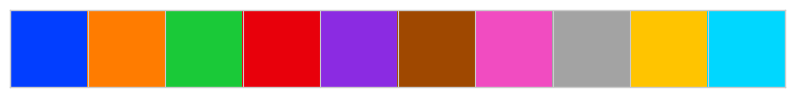

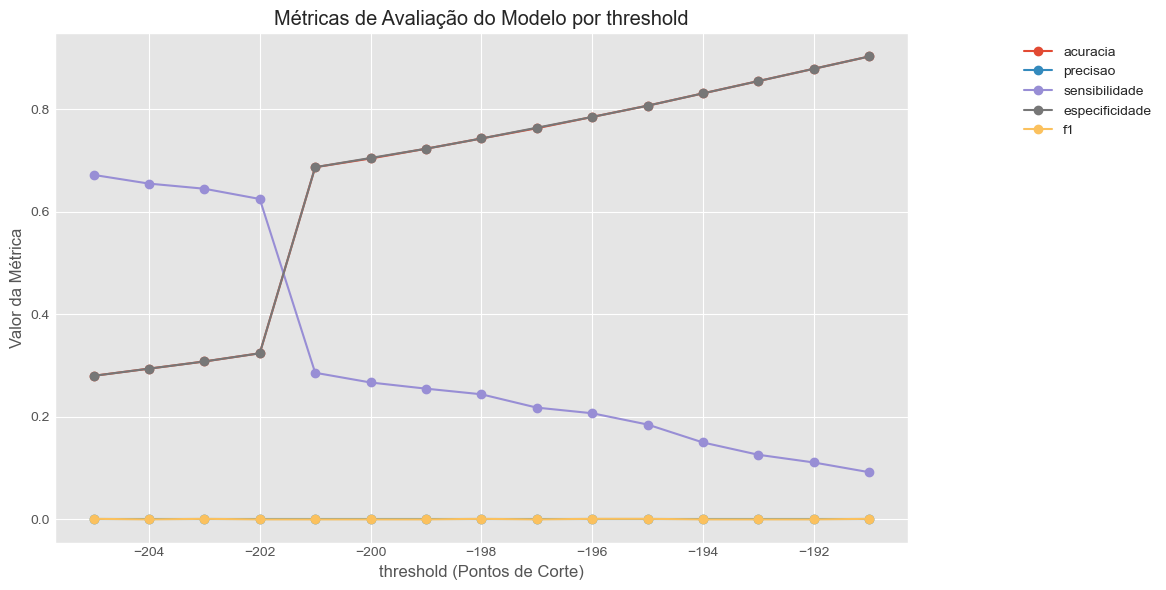

In [30]:
tabela_avaliacao = aval_modelo_corte_tabela(df['Y'], df['DIF_DATA_MIN'], beta = 1.5, pontos_de_corte = np.arange(-205, -190, 1))
# tabela_avaliacao.to_clipboard()
aval_modelo_corte_grafico(tabela_avaliacao.drop(['custo_who','fraude_evitada','delta'], axis=1))

In [31]:
df['DIF_DATA_MIN_bin'] = 0
df['DIF_DATA_MIN_bin'][df['DIF_DATA_MIN'] >= -198] = 1

display(count_table(df, 'Y', 'DIF_DATA_MIN_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DIF_DATA_MIN_bin', 'Y'))

Y,0,1,Total,P-value,Test_Used
DIF_DATA_MIN_bin,,,,,
0,99.97,0.03,100.00,0.489,Chi-squared
1,99.97,0.03,100.00,nan,nan


Y,0,1
DIF_DATA_MIN_bin,,
0,1640390,450
1,567236,145


# criando adaptação temporal para as variaveis

## vars numericas

In [32]:
df.columns

Index(['COD_STATUS', 'DTH_INCLUSAO', 'COD_BENEFICIO', 'COD_SOLICBENEFICIO',
       'NUM_BENEFICIO', 'NUM_CPF', 'NOM_ESPECIEBENEFICIO', 'TIPO_BENEFICIO',
       'DTA_INI_SOLICITACAO', 'DTAHRA_INI_SOLICITACAO', 'DTA_VALIDADE_CREDITO',
       'DTA_CONTROLE', 'COD_LOJA_ATIVACAO', 'NOME_LOJA_ATIVACAO',
       'UF_LOJA_ATIVACAO', 'COD_LOJA_OFICIAL', 'NOME_LOJA_OFICIAL',
       'UF_LOJA_OFICIAL', 'COMPARA_LOJA', 'COMPARA_LOJA_UF',
       'DTA_NASCIMENTO_CADUNICO', 'DTA_NASCIMENTO_CAD_BENE', 'COMPARA_NASC',
       'SLG_SEXO', 'NOM_PAPELPESSOA', 'CIDADE_CADASTRO', 'UF_CADASTRO',
       'QTDE_CPFS_COM_MESMO_TELEFONE', 'TELEFONE_COMPARTILHADO',
       'QTDE_TELEFONES_COMPARTILHADOS', 'TPO_DOCUMENTO', 'DES_DOCUMENTO',
       'DES_MEIOPAGAMENTO', 'VLR_TOTALCREDITO', 'SEQ_ORGAOPAGADOR', 'PRACA',
       'NUM_LOTEPREGAO', 'DATA_BIOMETRIA', 'DES_METODO', 'COD_SIGLA',
       'SCORE_UNICO', 'DIF_DATA_MIN', 'INDEXX', 'Y', 'STATUS_WHO',
       'SCORE_UNICO_CAT', 'DIF_DATA_MIN_bin'],
      dtype='object')

# Tratando o DataFrame

### Funções de tratamento dos dados - PIPELINE

In [33]:
for count, i in enumerate(df.columns):
    print(count, ":", i)

0 : COD_STATUS
1 : DTH_INCLUSAO
2 : COD_BENEFICIO
3 : COD_SOLICBENEFICIO
4 : NUM_BENEFICIO
5 : NUM_CPF
6 : NOM_ESPECIEBENEFICIO
7 : TIPO_BENEFICIO
8 : DTA_INI_SOLICITACAO
9 : DTAHRA_INI_SOLICITACAO
10 : DTA_VALIDADE_CREDITO
11 : DTA_CONTROLE
12 : COD_LOJA_ATIVACAO
13 : NOME_LOJA_ATIVACAO
14 : UF_LOJA_ATIVACAO
15 : COD_LOJA_OFICIAL
16 : NOME_LOJA_OFICIAL
17 : UF_LOJA_OFICIAL
18 : COMPARA_LOJA
19 : COMPARA_LOJA_UF
20 : DTA_NASCIMENTO_CADUNICO
21 : DTA_NASCIMENTO_CAD_BENE
22 : COMPARA_NASC
23 : SLG_SEXO
24 : NOM_PAPELPESSOA
25 : CIDADE_CADASTRO
26 : UF_CADASTRO
27 : QTDE_CPFS_COM_MESMO_TELEFONE
28 : TELEFONE_COMPARTILHADO
29 : QTDE_TELEFONES_COMPARTILHADOS
30 : TPO_DOCUMENTO
31 : DES_DOCUMENTO
32 : DES_MEIOPAGAMENTO
33 : VLR_TOTALCREDITO
34 : SEQ_ORGAOPAGADOR
35 : PRACA
36 : NUM_LOTEPREGAO
37 : DATA_BIOMETRIA
38 : DES_METODO
39 : COD_SIGLA
40 : SCORE_UNICO
41 : DIF_DATA_MIN
42 : INDEXX
43 : Y
44 : STATUS_WHO
45 : SCORE_UNICO_CAT
46 : DIF_DATA_MIN_bin


### marcação status == cancelados

In [34]:
display(tabela_cont(df, 'COD_STATUS', 'Y'))
display(count_table_percent(df, 'COD_STATUS', 'Y', 'Linha'))

Y,0,1
COD_STATUS,,
33,2206932,593
34,694,2


Y,0,1
COD_STATUS,,
33,99.97,0.03
34,99.71,0.29


## divergencia de cadastro UNICO vs BENEFICIO

In [35]:
df['comparacao_cadastro_unico_e_bene'] = df['DTA_NASCIMENTO_CADUNICO'] == df['DTA_NASCIMENTO_CAD_BENE']
df['comparacao_cadastro_unico_e_bene'].value_counts()

display(count_table(df, 'Y', 'comparacao_cadastro_unico_e_bene', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'comparacao_cadastro_unico_e_bene', 'Y'))

Y,0,1,Total,P-value,Test_Used
comparacao_cadastro_unico_e_bene,,,,,
False,99.96,0.04,100.00,0.794,Chi-squared
True,99.97,0.03,100.00,nan,nan


Y,0,1
comparacao_cadastro_unico_e_bene,,
False,4498,2
True,2203128,593


### DTA_NASCIMENTO -> Idade

In [36]:
df['DTA_NASCIMENTO_CAD_BENE'] = pd.to_datetime(df['DTA_NASCIMENTO_CAD_BENE'], format='%d/%m/%Y', errors='coerce')
df['DTA_NASCIMENTO_CADUNICO'] = pd.to_datetime(df['DTA_NASCIMENTO_CADUNICO'], format='%d/%m/%Y', errors='coerce')
df['DTA_INI_SOLICITACAO'] = pd.to_datetime(df['DTA_INI_SOLICITACAO'], format='%d/%m/%Y', errors='coerce')

# Usa a data de nascimento principal, e preenche os nulos com a alternativa
df['DTA_NASCIMENTO'] = df['DTA_NASCIMENTO_CAD_BENE']
data_nasc = df['DTA_NASCIMENTO'].combine_first(df['DTA_NASCIMENTO_CADUNICO'])
data_ref = df['DTA_INI_SOLICITACAO']

# Calcula a idade vetorizadamente
anos = data_ref.dt.year - data_nasc.dt.year

aniversario_ja_passou = (data_ref.dt.month > data_nasc.dt.month) | (
    (data_ref.dt.month == data_nasc.dt.month) & (data_ref.dt.day >= data_nasc.dt.day)
)

# Aplica a idade apenas onde há dados válidos
df['IDADE'] = np.where(
    data_nasc.notna() & data_ref.notna(),
    anos - (~aniversario_ja_passou),
    np.nan
)

df['IDADE'].isnull().sum()

0

In [37]:
display(df.groupby(['Y'])['IDADE'].describe().round(0))
print(summary_num_parametric_groups(df, 'IDADE', 'Y'))

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,2207626.0,49.0,15.0,0.0,36.0,50.0,62.0,178.0
1,595.0,53.0,17.0,17.0,40.0,55.0,65.0,102.0


       Y         resumo P-value Test_Used
0  Total  48.75 ± 15.01  <0.001    T Test
1      0  48.75 ± 15.01     NaN       NaN
2      1  53.38 ± 17.25     NaN       NaN


In [38]:
filtro = df['IDADE'] > 100
display(df[filtro].groupby(['Y'])['IDADE'].describe().round(0))
#print(summary_num_parametric_groups(df[filtro], 'IDADE', 'Y'))

df['IDADE'][df['IDADE'] > 105] = df['IDADE'].median()

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,92.0,105.0,9.0,101.0,101.0,103.0,105.0,178.0
1,2.0,102.0,0.0,102.0,102.0,102.0,102.0,102.0


# Idade Categorica

In [39]:
# Definindo os limites das faixas etárias
bins = list(range(0, 111, 10))  # Vai de 0 até 110, pulando de 10 em 10

# Criando os labels das faixas etárias
labels = [f'{bins[i]}–{bins[i+1]-1}' for i in range(len(bins)-1)]
# Exemplo de labels: '0–9', '10–19', ..., '100–109'

# Criando a coluna categórica
df['IDADE_CAT10_10'] = pd.cut(df['IDADE'], bins=bins, labels=labels, right=False, include_lowest=True)
print(df['IDADE_CAT10_10'].value_counts().sort_index())

display(count_table(df, 'Y', 'IDADE_CAT10_10', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'IDADE_CAT10_10', 'Y'))

IDADE_CAT10_10
0–9            28
10–19       19950
20–29      275098
30–39      380142
40–49      400244
50–59      454033
60–69      576358
70–79       74334
80–89       24172
90–99        3745
100–109       117
Name: count, dtype: int64


Y,0,1,Total,P-value,Test_Used
IDADE_CAT10_10,,,,,
0–9,100.00,0.00,100.00,<0.001,Chi-squared
10–19,99.97,0.03,100.00,nan,nan
20–29,99.98,0.02,100.00,nan,nan
30–39,99.98,0.02,100.00,nan,nan
40–49,99.98,0.02,100.00,nan,nan
50–59,99.98,0.02,100.00,nan,nan
60–69,99.98,0.02,100.00,nan,nan
70–79,99.89,0.11,100.00,nan,nan
80–89,99.89,0.11,100.00,nan,nan


Y,0,1
IDADE_CAT10_10,,
0–9,28,0
10–19,19945,5
20–29,275038,60
30–39,380060,82
40–49,400145,99
50–59,453925,108
60–69,576231,127
70–79,74251,83
80–89,24146,26


In [40]:
df_base = df[df['Y'] == 1]
top_categorias = df_base['IDADE_CAT10_10'].value_counts()
top_categorias.loc[lambda x: x > 0]

IDADE_CAT10_10
60–69      127
50–59      108
40–49       99
70–79       83
30–39       82
20–29       60
80–89       26
10–19        5
90–99        3
100–109      2
Name: count, dtype: int64

### DTA_INI_SOLICITACAO - DTH_INCLUSAO => DIAS_ATIVACAO (qtde de dias que o cara demorou para ativar o beneficio apartir da data que recebemos o beneficio na crefisa)

In [41]:
df['DIAS_ATIVACAO'] = (df['DTA_INI_SOLICITACAO'] - df['DTH_INCLUSAO'])/np.timedelta64(1, 'D')
display(df.groupby(['Y'])['DIAS_ATIVACAO'].describe().round(0))
display(summary_num_parametric_groups(df, 'DIAS_ATIVACAO', 'Y'))

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,2207619.0,20.0,67.0,-142.0,10.0,14.0,16.0,1806.0
1,595.0,53.0,142.0,0.0,14.0,17.0,35.0,1342.0


,Y,resumo,P-value,Test_Used
0,Total,20.06 ± 67.34,<0.001,T Test
1,0,20.05 ± 67.31,NaN,NaN
2,1,52.71 ± 142.34,NaN,NaN


,threshold,tn,fp,fn,tp,acuracia,precisao,sensibilidade,especificidade,f1,custo_who,fraude_evitada,delta
0,8,415398,1792228,75,520,0.188,0.000,0.874,0.188,0.001,17927480,4160000,-13767480
1,9,464653,1742973,82,513,0.211,0.000,0.862,0.210,0.001,17434860,4104000,-13330860
2,10,515137,1692489,86,509,0.234,0.000,0.855,0.233,0.001,16929980,4072000,-12857980
3,11,574525,1633101,97,498,0.260,0.000,0.837,0.260,0.001,16335990,3984000,-12351990
4,12,595656,1611970,101,494,0.270,0.000,0.830,0.270,0.001,16124640,3952000,-12172640
5,13,601414,1606212,104,491,0.273,0.000,0.825,0.272,0.001,16067030,3928000,-12139030
6,14,740441,1467185,120,475,0.336,0.000,0.798,0.335,0.001,14676600,3800000,-10876600
7,15,1416705,790921,220,375,0.642,0.000,0.630,0.642,0.001,7912960,3000000,-4912960
8,16,1620300,587326,253,342,0.734,0.001,0.575,0.734,0.001,5876680,2736000,-3140680
9,17,1746456,461170,279,316,0.791,0.001,0.531,0.791,0.001,4614860,2528000,-2086860


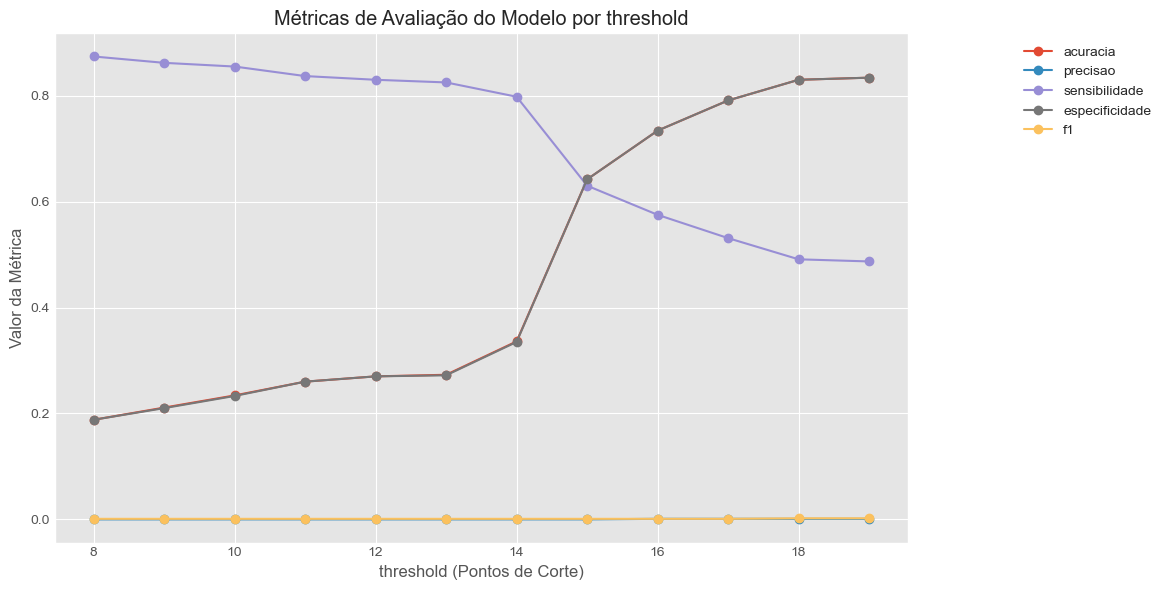

In [42]:
tabela_avaliacao = aval_modelo_corte_tabela(df['Y'], df['DIAS_ATIVACAO'], beta = 1.5, pontos_de_corte = np.arange(8, 20, 1))
display(tabela_avaliacao)
aval_modelo_corte_grafico(tabela_avaliacao.drop(['custo_who','fraude_evitada','delta'], axis=1))

In [43]:
df['DIAS_ATIVACAO_bin'] = 0
df['DIAS_ATIVACAO_bin'][df['DIAS_ATIVACAO'] >= 15] = 1

display(count_table(df, 'Y', 'DIAS_ATIVACAO_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DIAS_ATIVACAO_bin', 'Y'))

Y,0,1,Total,P-value,Test_Used
DIAS_ATIVACAO_bin,,,,,
0,99.98,0.02,100.00,<0.001,Chi-squared
1,99.95,0.05,100.00,nan,nan


Y,0,1
DIAS_ATIVACAO_bin,,
0,1416705,220
1,790921,375


### DTA_INI_SOLICITACAO - DTA_VAILIDADE_CREDITO => DIAS_ATIVACAO (qtde de dias que o cara demorou para ativar o beneficio apartir da data o INSS mandou o primeiro pagamento)

In [44]:
df['DIAS_ATIVACAO2'] = (df['DTA_INI_SOLICITACAO'] - df['DTA_VALIDADE_CREDITO'])/np.timedelta64(1, 'D') 
df['DIAS_ATIVACAO2'].describe().round()

count    2208214.0
mean           5.0
std           72.0
min         -820.0
25%           -4.0
50%            0.0
75%            1.0
max         4460.0
Name: DIAS_ATIVACAO2, dtype: float64

In [45]:
display(df.groupby(['Y'])['DIAS_ATIVACAO2'].describe().round(0))
display(summary_num_parametric_groups(df, 'DIAS_ATIVACAO2', 'Y'))

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,2207619.0,5.0,72.0,-820.0,-4.0,0.0,1.0,4460.0
1,595.0,30.0,148.0,-774.0,0.0,3.0,21.0,1329.0


,Y,resumo,P-value,Test_Used
0,Total,5.05 ± 72.30,<0.001,T Test
1,0,5.04 ± 72.27,NaN,NaN
2,1,30.09 ± 147.84,NaN,NaN


,threshold,tn,fp,fn,tp,acuracia,precisao,sensibilidade,especificidade,f1,custo_who,fraude_evitada,delta
0,-20,6377,2201249,11,584,0.003,0.000,0.982,0.003,0.001,22018330,4672000,-17346330
1,-19,7644,2199982,12,583,0.004,0.000,0.980,0.003,0.001,22005650,4664000,-17341650
2,-18,8990,2198636,12,583,0.004,0.000,0.980,0.004,0.001,21992190,4664000,-17328190
3,-17,10265,2197361,12,583,0.005,0.000,0.980,0.005,0.001,21979440,4664000,-17315440
4,-16,11668,2195958,14,581,0.006,0.000,0.976,0.005,0.001,21965390,4648000,-17317390
5,-15,14957,2192669,14,581,0.007,0.000,0.976,0.007,0.001,21932500,4648000,-17284500
6,-14,20333,2187293,14,581,0.009,0.000,0.976,0.009,0.001,21878740,4648000,-17230740
7,-13,56145,2151481,21,574,0.026,0.000,0.965,0.025,0.001,21520550,4592000,-16928550
8,-12,133082,2074544,34,561,0.061,0.000,0.943,0.060,0.001,20751050,4488000,-16263050
9,-11,212886,1994740,41,554,0.097,0.000,0.931,0.096,0.001,19952940,4432000,-15520940


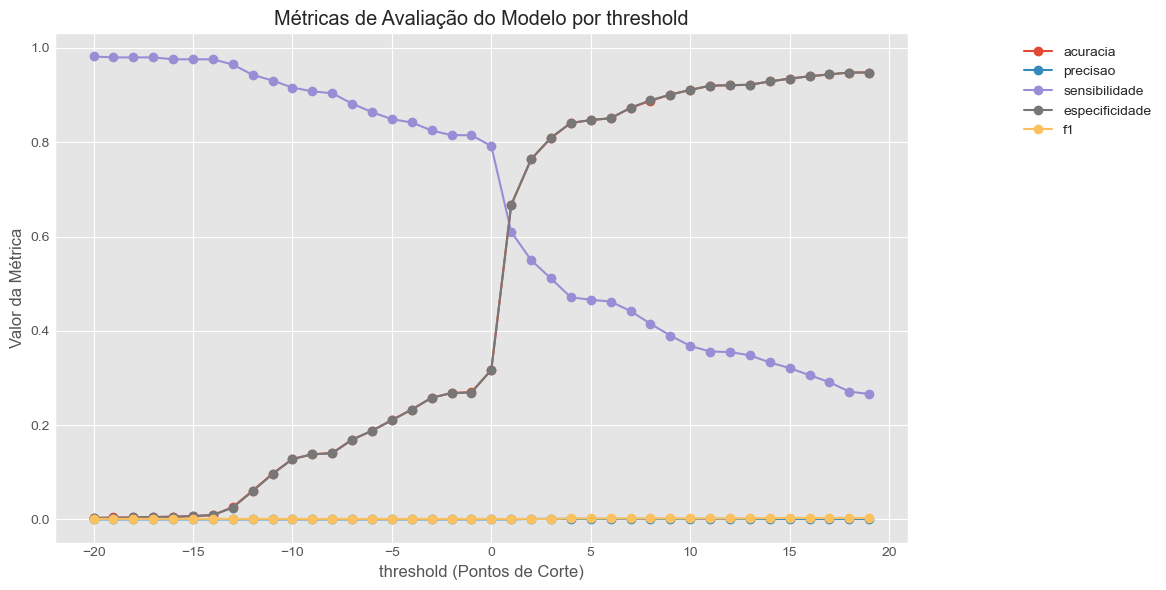

In [46]:
tabela_avaliacao = aval_modelo_corte_tabela(df['Y'], df['DIAS_ATIVACAO2'], beta = 1.5, pontos_de_corte = np.arange(-20, 20, 1))
display(tabela_avaliacao)
aval_modelo_corte_grafico(tabela_avaliacao.drop(['custo_who','fraude_evitada','delta'], axis=1))

In [47]:
df['DIAS_ATIVACAO2_bin'] = 0
df['DIAS_ATIVACAO2_bin'][df['DIAS_ATIVACAO2'] >= 2] = 1

display(count_table(df, 'Y', 'DIAS_ATIVACAO2_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DIAS_ATIVACAO2_bin', 'Y'))

Y,0,1,Total,P-value,Test_Used
DIAS_ATIVACAO2_bin,,,,,
0,99.98,0.02,100.00,<0.001,Chi-squared
1,99.94,0.06,100.00,nan,nan


Y,0,1
DIAS_ATIVACAO2_bin,,
0,1687443,268
1,520183,327


### Dia da semana que ativou o beneficio

In [48]:
df.columns

Index(['COD_STATUS', 'DTH_INCLUSAO', 'COD_BENEFICIO', 'COD_SOLICBENEFICIO',
       'NUM_BENEFICIO', 'NUM_CPF', 'NOM_ESPECIEBENEFICIO', 'TIPO_BENEFICIO',
       'DTA_INI_SOLICITACAO', 'DTAHRA_INI_SOLICITACAO', 'DTA_VALIDADE_CREDITO',
       'DTA_CONTROLE', 'COD_LOJA_ATIVACAO', 'NOME_LOJA_ATIVACAO',
       'UF_LOJA_ATIVACAO', 'COD_LOJA_OFICIAL', 'NOME_LOJA_OFICIAL',
       'UF_LOJA_OFICIAL', 'COMPARA_LOJA', 'COMPARA_LOJA_UF',
       'DTA_NASCIMENTO_CADUNICO', 'DTA_NASCIMENTO_CAD_BENE', 'COMPARA_NASC',
       'SLG_SEXO', 'NOM_PAPELPESSOA', 'CIDADE_CADASTRO', 'UF_CADASTRO',
       'QTDE_CPFS_COM_MESMO_TELEFONE', 'TELEFONE_COMPARTILHADO',
       'QTDE_TELEFONES_COMPARTILHADOS', 'TPO_DOCUMENTO', 'DES_DOCUMENTO',
       'DES_MEIOPAGAMENTO', 'VLR_TOTALCREDITO', 'SEQ_ORGAOPAGADOR', 'PRACA',
       'NUM_LOTEPREGAO', 'DATA_BIOMETRIA', 'DES_METODO', 'COD_SIGLA',
       'SCORE_UNICO', 'DIF_DATA_MIN', 'INDEXX', 'Y', 'STATUS_WHO',
       'SCORE_UNICO_CAT', 'DIF_DATA_MIN_bin',
       'comparacao_cadas

## Outras colunas

# valor do beneficio

In [49]:
display(df.groupby(['Y'])['VLR_TOTALCREDITO'].describe().round(0))
display(summary_num_parametric_groups(df, 'VLR_TOTALCREDITO', 'Y'))

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,2207619.0,11559.0,14477.0,1.0,3696.0,6435.0,14438.0,681941.0
1,595.0,17882.0,24102.0,88.0,5190.0,10816.0,20772.0,196486.0


,Y,resumo,P-value,Test_Used
0,Total,11560.44 ± 14481.20,<0.001,T Test
1,0,11558.73 ± 14477.38,NaN,NaN
2,1,17881.91 ± 24101.76,NaN,NaN


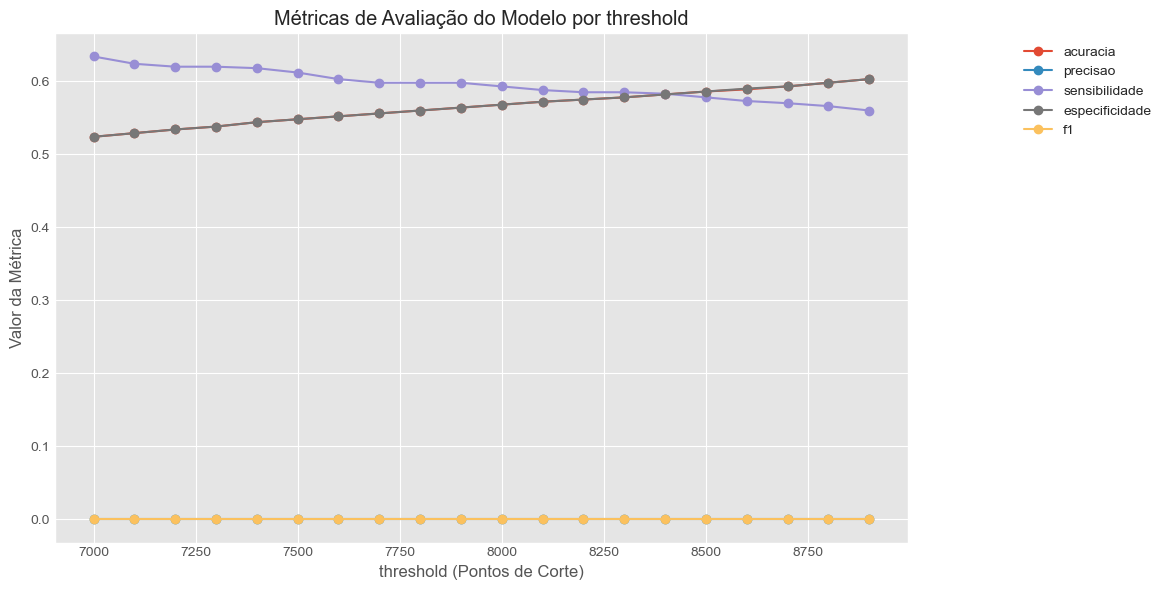

In [50]:
tabela_avaliacao = aval_modelo_corte_tabela(df['Y'], df['VLR_TOTALCREDITO'], beta = 1.5, pontos_de_corte = np.arange(7000, 9000, 100))
aval_modelo_corte_grafico(tabela_avaliacao.drop(['custo_who','fraude_evitada','delta'], axis=1))

In [51]:
df['VLR_TOTALCREDITO_bin'] = 0
df['VLR_TOTALCREDITO_bin'][df['VLR_TOTALCREDITO'] >= 8400] = 1

display(count_table(df, 'Y', 'VLR_TOTALCREDITO_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'VLR_TOTALCREDITO_bin', 'Y'))

Y,0,1,Total,P-value,Test_Used
VLR_TOTALCREDITO_bin,,,,,
0,99.98,0.02,100.00,<0.001,Chi-squared
1,99.96,0.04,100.00,nan,nan


Y,0,1
VLR_TOTALCREDITO_bin,,
0,1284018,248
1,923608,347


In [52]:
df['VLR_TOTALCREDITO'].describe().round(0)

count    2208214.0
mean       11560.0
std        14481.0
min            1.0
25%         3696.0
50%         6436.0
75%        14438.0
max       681941.0
Name: VLR_TOTALCREDITO, dtype: float64

# VLR_TOTALCREDITO POR FAIXA

In [53]:
bins = list(range(0, 15000, 500)) + [np.inf]  # [0,1000,2000,...,14000,inf]

# Criando os rótulos das categorias
labels = [f'{bins[i]}–{int(bins[i+1]-1)}' for i in range(len(bins)-2)]
labels.append('15000+')  # Último label para valores >= 15000

# Criando a coluna categórica no dataframe
df['VLR_TOTALCREDITO_500em500'] = pd.cut(
    df['VLR_TOTALCREDITO'],
    bins=bins,
    labels=labels,
    right=False,          # intervalo fechado à esquerda, aberto à direita
    include_lowest=True   # inclui o valor mais baixo (ex: 0) na primeira faixa
)

display(count_table(df, 'Y', 'VLR_TOTALCREDITO_500em500', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'VLR_TOTALCREDITO_500em500', 'Y'))
##################################################################################################
bins = list(range(0, 15000, 1000)) + [np.inf]  # [0,1000,2000,...,14000,inf]

# Criando os rótulos das categorias
labels = [f'{bins[i]}–{int(bins[i+1]-1)}' for i in range(len(bins)-2)]
labels.append('15000+')  # Último label para valores >= 15000

# Criando a coluna categórica no dataframe
df['VLR_TOTALCREDITO_1000em1000'] = pd.cut(
    df['VLR_TOTALCREDITO'],
    bins=bins,
    labels=labels,
    right=False,          # intervalo fechado à esquerda, aberto à direita
    include_lowest=True   # inclui o valor mais baixo (ex: 0) na primeira faixa
)

display(count_table(df, 'Y', 'VLR_TOTALCREDITO_1000em1000', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'VLR_TOTALCREDITO_1000em1000', 'Y'))

Y,0,1,Total,P-value,Test_Used
VLR_TOTALCREDITO_500em500,,,,,
0–499,99.98,0.02,100.00,<0.001,Chi-squared
500–999,99.99,0.01,100.00,nan,nan
1000–1499,99.99,0.01,100.00,nan,nan
1500–1999,99.98,0.02,100.00,nan,nan
2000–2499,99.99,0.01,100.00,nan,nan
2500–2999,99.98,0.02,100.00,nan,nan
3000–3499,99.99,0.01,100.00,nan,nan
3500–3999,99.98,0.02,100.00,nan,nan
4000–4499,99.99,0.01,100.00,nan,nan


Y,0,1
VLR_TOTALCREDITO_500em500,,
0–499,28506,5
500–999,64515,7
1000–1499,73585,8
1500–1999,81962,20
2000–2499,82074,12
2500–2999,90233,22
3000–3499,100626,14
3500–3999,80376,15
4000–4499,94082,14


Y,0,1,Total,P-value,Test_Used
VLR_TOTALCREDITO_1000em1000,,,,,
0–999,99.99,0.01,100.00,<0.001,Chi-squared
1000–1999,99.98,0.02,100.00,nan,nan
2000–2999,99.98,0.02,100.00,nan,nan
3000–3999,99.98,0.02,100.00,nan,nan
4000–4999,99.98,0.02,100.00,nan,nan
5000–5999,99.98,0.02,100.00,nan,nan
6000–6999,99.98,0.02,100.00,nan,nan
7000–7999,99.97,0.03,100.00,nan,nan
8000–8999,99.98,0.02,100.00,nan,nan


Y,0,1
VLR_TOTALCREDITO_1000em1000,,
0–999,93021,12
1000–1999,155547,28
2000–2999,172307,34
3000–3999,181002,29
4000–4999,194468,35
5000–5999,250379,58
6000–6999,110502,22
7000–7999,95613,24
8000–8999,88094,20


# sexo do cliente

In [54]:
display(count_table(df, 'Y', 'SLG_SEXO', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'SLG_SEXO', 'Y'))

Y,0,1,Total,P-value,Test_Used
SLG_SEXO,,,,,
F,59.03,51.09,59.03,<0.001,Chi-squared
M,40.97,48.91,40.97,nan,nan
O,0.00,0.00,0.00,nan,nan


Y,0,1
SLG_SEXO,,
F,1303197,304
M,904424,291
O,5,0


In [55]:
df['SLG_SEXO'][~df['SLG_SEXO'].isin(['F','M'])] = 'F'
df['SLG_SEXO'] = df['SLG_SEXO'].map({'M': 1, 'F': 0})

# NOM_PAPELPESSOA

In [56]:
df['NOM_PAPELPESSOA'].value_counts()

NOM_PAPELPESSOA
TITULAR                2084605
REPRESENTANTE LEGAL     123568
TERCEIRO                    41
Name: count, dtype: int64

In [57]:
display(count_table(df, 'Y', 'NOM_PAPELPESSOA', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'NOM_PAPELPESSOA', 'Y'))

Y,0,1,Total,P-value,Test_Used
NOM_PAPELPESSOA,,,,,
REPRESENTANTE LEGAL,99.98,0.02,100.00,0.333,Chi-squared
TERCEIRO,100.00,0.00,100.00,nan,nan
TITULAR,99.97,0.03,100.00,nan,nan


Y,0,1
NOM_PAPELPESSOA,,
REPRESENTANTE LEGAL,123543,25
TERCEIRO,41,0
TITULAR,2084035,570


# CIDADE_CADASTRO

In [58]:
display(count_table(df, 'Y', 'UF_CADASTRO', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'UF_CADASTRO', 'Y'))

Y,0,1,Total,P-value,Test_Used
UF_CADASTRO,,,,,
AC,99.96,0.04,100.00,<0.001,Chi-squared
AL,99.97,0.03,100.00,nan,nan
AM,99.96,0.04,100.00,nan,nan
AP,99.98,0.02,100.00,nan,nan
BA,99.99,0.01,100.00,nan,nan
CE,99.98,0.02,100.00,nan,nan
DF,99.94,0.06,100.00,nan,nan
ES,100.00,0.00,100.00,nan,nan
GO,99.98,0.02,100.00,nan,nan


Y,0,1
UF_CADASTRO,,
AC,15789,6
AL,6345,2
AM,69516,29
AP,8397,2
BA,180203,22
CE,196731,38
DF,13876,8
ES,15596,0
GO,19715,4


In [59]:
# Dicionário de mapeamento de estados para suas regiões
regioes = {
    'AC': 'Norte', 'AP': 'Norte', 'AM': 'Norte', 'PA': 'Norte', 'RO': 'Norte', 'RR': 'Norte', 'TO': 'Norte',
    'AL': 'Nordeste', 'BA': 'Nordeste', 'CE': 'Nordeste', 'MA': 'Nordeste', 'PB': 'Nordeste',
    'PE': 'Nordeste', 'PI': 'Nordeste', 'RN': 'Nordeste', 'SE': 'Nordeste',
    'DF': 'Centro-Oeste', 'GO': 'Centro-Oeste', 'MS': 'Centro-Oeste', 'MT': 'Centro-Oeste',
    'ES': 'Sudeste', 'MG': 'Sudeste', 'RJ': 'Sudeste', 'SP': 'Sudeste',
    'PR': 'Sul', 'RS': 'Sul', 'SC': 'Sul'
}

# Função para mapear UF à sua região
def obter_regiao(uf):
    if pd.isna(uf) or uf == 'ND' or uf == '32':  # Lidar com valores inválidos
        return np.nan
    return regioes.get(uf, np.nan)

# Criar nova coluna 'REGIAO' com base no mapeamento
df['UF_CADASTRO_REGIAO'] = df['UF_CADASTRO'].apply(obter_regiao)
display(df['UF_CADASTRO_REGIAO'].value_counts())

display(count_table(df, 'Y', 'UF_CADASTRO_REGIAO', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'UF_CADASTRO_REGIAO', 'Y'))

UF_CADASTRO_REGIAO
Sudeste         975201
Nordeste        756864
Norte           313477
Sul             106791
Centro-Oeste     55584
Name: count, dtype: int64

Y,0,1,Total,P-value,Test_Used
UF_CADASTRO_REGIAO,,,,,
Centro-Oeste,99.97,0.03,100.00,0.007,Chi-squared
Nordeste,99.97,0.03,100.00,nan,nan
Norte,99.97,0.03,100.00,nan,nan
Sudeste,99.97,0.03,100.00,nan,nan
Sul,99.99,0.01,100.00,nan,nan


Y,0,1
UF_CADASTRO_REGIAO,,
Centro-Oeste,55570,14
Nordeste,756674,190
Norte,313379,98
Sudeste,974920,281
Sul,106779,12


# Variaveis de localidade

In [60]:
print(df[['COD_LOJA_ATIVACAO','NOME_LOJA_ATIVACAO','UF_LOJA_ATIVACAO',
'COD_LOJA_OFICIAL','NOME_LOJA_OFICIAL','UF_LOJA_OFICIAL',
'COMPARA_LOJA','COMPARA_LOJA_UF',
'CIDADE_CADASTRO','UF_CADASTRO']].isnull().sum())

COD_LOJA_ATIVACAO       0
NOME_LOJA_ATIVACAO    139
UF_LOJA_ATIVACAO      139
COD_LOJA_OFICIAL        7
NOME_LOJA_OFICIAL       7
UF_LOJA_OFICIAL         7
COMPARA_LOJA            0
COMPARA_LOJA_UF         0
CIDADE_CADASTRO        30
UF_CADASTRO           304
dtype: int64


# TELEFONE

In [61]:
df[['QTDE_CPFS_COM_MESMO_TELEFONE', 'TELEFONE_COMPARTILHADO','QTDE_TELEFONES_COMPARTILHADOS']]#.isnull().sum()

,QTDE_CPFS_COM_MESMO_TELEFONE,TELEFONE_COMPARTILHADO,QTDE_TELEFONES_COMPARTILHADOS
0,1.0,0,0.0
1,2.0,0,0.0
2,1.0,0,0.0
3,1.0,0,0.0
4,1.0,0,0.0
...,...,...,...
2208216,2.0,0,0.0
2208217,1.0,0,0.0
2208218,1.0,0,0.0
2208219,1.0,0,0.0


In [62]:
display(count_table(df, 'Y', 'TELEFONE_COMPARTILHADO', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'TELEFONE_COMPARTILHADO', 'Y'))

Y,0,1,Total,P-value,Test_Used
TELEFONE_COMPARTILHADO,,,,,
0,99.98,0.02,100.00,<0.001,Chi-squared
1,99.93,0.07,100.00,nan,nan


Y,0,1
TELEFONE_COMPARTILHADO,,
0,2051121,490
1,152813,101


In [63]:
df['TELEFONE_COMPARTILHADO'][df['TELEFONE_COMPARTILHADO'].isnull()] = '0'
df['TELEFONE_COMPARTILHADO'] = df['TELEFONE_COMPARTILHADO'].astype('O')

In [64]:
display(df.groupby(['Y'])['QTDE_CPFS_COM_MESMO_TELEFONE'].describe().round(0))
display(summary_num_parametric_groups(df, 'QTDE_CPFS_COM_MESMO_TELEFONE', 'Y'))

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,2203934.0,2.0,1.0,1.0,1.0,1.0,2.0,57.0
1,591.0,2.0,1.0,1.0,1.0,1.0,2.0,5.0


,Y,resumo,P-value,Test_Used
0,Total,1.73 ± 0.94,0.004,T Test
1,0,1.73 ± 0.94,NaN,NaN
2,1,1.62 ± 0.88,NaN,NaN


In [65]:
display(df.groupby(['Y'])['QTDE_TELEFONES_COMPARTILHADOS'].describe().round(0))
display(summary_num_parametric_groups(df, 'QTDE_TELEFONES_COMPARTILHADOS', 'Y'))

,count,mean,std,min,25%,50%,75%,max
Y,,,,,,,,
0,2203934.0,0.0,2.0,0.0,0.0,0.0,0.0,3492.0
1,591.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0


,Y,resumo,P-value,Test_Used
0,Total,0.08 ± 2.37,0.210,T Test
1,0,0.08 ± 2.37,NaN,NaN
2,1,0.20 ± 0.49,NaN,NaN


# TPO_DOCUMENTO

In [66]:
display(count_table(df, 'Y', 'TPO_DOCUMENTO', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'TPO_DOCUMENTO', 'Y'))

Y,0,1,Total,P-value,Test_Used
TPO_DOCUMENTO,,,,,
1,99.97,0.03,100.00,<0.001,Chi-squared
23,99.95,0.05,100.00,nan,nan
24,100.00,0.00,100.00,nan,nan
25,99.97,0.03,100.00,nan,nan
26,100.00,0.00,100.00,nan,nan
27,99.69,0.31,100.00,nan,nan
28,100.00,0.00,100.00,nan,nan
29,100.00,0.00,100.00,nan,nan
35,100.00,0.00,100.00,nan,nan


Y,0,1
TPO_DOCUMENTO,,
1,2098552,541
23,74733,40
24,810,0
25,31929,11
26,431,0
27,956,3
28,40,0
29,100,0
35,1,0


In [67]:
df['TPO_DOCUMENTO_bin'] = 0
df['TPO_DOCUMENTO_bin'][df['TPO_DOCUMENTO'].isin(['1','23','25','27'])] = 1
display(count_table(df, 'Y', 'TPO_DOCUMENTO_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'TPO_DOCUMENTO_bin', 'Y'))

Y,0,1,Total,P-value,Test_Used
TPO_DOCUMENTO_bin,,,,,
0,100.00,0.00,100.00,1.000,Chi-squared
1,99.97,0.03,100.00,nan,nan


Y,0,1
TPO_DOCUMENTO_bin,,
0,1456,0
1,2206170,595


In [68]:
df['TPO_DOCUMENTO'] = df['TPO_DOCUMENTO'].astype('O')
df['TPO_DOCUMENTO_bin'] = df['TPO_DOCUMENTO_bin'].astype('O')

# DES_DOCUMENTO

In [69]:
display(count_table(df, 'Y', 'DES_DOCUMENTO', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DES_DOCUMENTO', 'Y'))

Y,0,1,Total,P-value,Test_Used
DES_DOCUMENTO,,,,,
CARTEIRA CONSELHO REGIONAL,100.00,0.00,100.00,<0.001,Chi-squared
CARTEIRA NACIONAL HABILITACAO,99.97,0.03,100.00,nan,nan
CARTEIRA PROFISSIONAL,99.69,0.31,100.00,nan,nan
DOCUMENTO DE IDENTIFICACAO,99.97,0.03,100.00,nan,nan
FUNCIONAL,100.00,0.00,100.00,nan,nan
PASSAPORTE,100.00,0.00,100.00,nan,nan
REGISTRO NAC ESTRANGEIRO,100.00,0.00,100.00,nan,nan
RG,99.95,0.05,100.00,nan,nan
TERMO OPCAO TRANSFERENCIA CARTAO MAGNETICO,100.00,0.00,100.00,nan,nan


Y,0,1
DES_DOCUMENTO,,
CARTEIRA CONSELHO REGIONAL,810,0
CARTEIRA NACIONAL HABILITACAO,31929,11
CARTEIRA PROFISSIONAL,956,3
DOCUMENTO DE IDENTIFICACAO,2098552,541
FUNCIONAL,100,0
PASSAPORTE,40,0
REGISTRO NAC ESTRANGEIRO,431,0
RG,74733,40
TERMO OPCAO TRANSFERENCIA CARTAO MAGNETICO,1,0


In [70]:
DES_DOCUMENTO_fraudados = list(df['DES_DOCUMENTO'][df['Y'] == 1].unique())
print(DES_DOCUMENTO_fraudados)

['DOCUMENTO DE IDENTIFICACAO', 'RG', 'CARTEIRA NACIONAL HABILITACAO', 'CARTEIRA PROFISSIONAL']


In [71]:
df['DES_DOCUMENTO_bin'] = 0
df['DES_DOCUMENTO_bin'][df['DES_DOCUMENTO'].isin(DES_DOCUMENTO_fraudados)] = 1
display(count_table(df, 'Y', 'DES_DOCUMENTO_bin', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DES_DOCUMENTO_bin', 'Y'))

Y,0,1,Total,P-value,Test_Used
DES_DOCUMENTO_bin,,,,,
0,100.00,0.00,100.00,1.000,Chi-squared
1,99.97,0.03,100.00,nan,nan


Y,0,1
DES_DOCUMENTO_bin,,
0,1456,0
1,2206170,595


In [72]:
display(pd.crosstab(df['NOM_ESPECIEBENEFICIO'], df['Y'], margins=True).sort_values(by=1))
display(count_table(df, 'Y', 'NOM_ESPECIEBENEFICIO', sentido_percent='col', apenas_fisher=False).sort_values(by=1))
display(count_table(df, 'Y', 'NOM_ESPECIEBENEFICIO', sentido_percent='lin', apenas_fisher=False).sort_values(by=1))

Y,0,1,All
NOM_ESPECIEBENEFICIO,,,
AMPARO POR IDADE DE TRABALHADOR RURAL,1,0,1
PENSAO POR MORTE DE EMPREGADO RURAL,7,0,7
PENSAO POR MORTE DE ANISTIADO,2,0,2
PENSAO POR MORTE (ACIDENTE DE TRABALHO),289,0,289
PENSAO POR MORTE DE SERVIDOR PUBLICO,1,0,1
PENSAO MENSAL VITALICIA(SERINGUEIRO),2,0,2
PENSAO MENSAL VITALICIA(DEP. SERINGUEIRO),135,0,135
PENSAO ESPECIAL HANSENIASE - LEI 11520/07,23,0,23
PENSAO DE VITIMA DA TALIDOMIDA,17,0,17


Y,0,1,Total,P-value,Test_Used
NOM_ESPECIEBENEFICIO,,,,,
AMPARO POR IDADE DE TRABALHADOR RURAL,0.00,0.00,0.00,<0.001,Chi-squared
PENSAO POR MORTE DE EMPREGADO RURAL,0.00,0.00,0.00,nan,nan
PENSAO POR MORTE DE ANISTIADO,0.00,0.00,0.00,nan,nan
PENSAO POR MORTE (ACIDENTE DE TRABALHO),0.01,0.00,0.01,nan,nan
PENSAO POR MORTE DE SERVIDOR PUBLICO,0.00,0.00,0.00,nan,nan
PENSAO MENSAL VITALICIA(SERINGUEIRO),0.00,0.00,0.00,nan,nan
PENSAO MENSAL VITALICIA(DEP. SERINGUEIRO),0.01,0.00,0.01,nan,nan
PENSAO ESPECIAL HANSENIASE - LEI 11520/07,0.00,0.00,0.00,nan,nan
PENSAO DE VITIMA DA TALIDOMIDA,0.00,0.00,0.00,nan,nan


Y,0,1,Total,P-value,Test_Used
NOM_ESPECIEBENEFICIO,,,,,
AMPARO POR IDADE DE TRABALHADOR RURAL,100.00,0.00,100.00,<0.001,Chi-squared
PENSAO ESPECIAL HANSENIASE - LEI 11520/07,100.00,0.00,100.00,nan,nan
PENSAO DE VITIMA DA TALIDOMIDA,100.00,0.00,100.00,nan,nan
BENEFICIO INDENIZATORIO A CARGO DA UNIAO,100.00,0.00,100.00,nan,nan
AUXILIO-SUPLEMENTAR (ACIDENTE DE TRABALHO) (BENEFICIO TEMPORARIO),100.00,0.00,100.00,nan,nan
RENDA MENSAL VITALICIA POR INVALIDEZ,100.00,0.00,100.00,nan,nan
PENSAO POR MORTE (ACIDENTE DE TRABALHO),100.00,0.00,100.00,nan,nan
AUXILIO RECLUSAO (BENEFICIO TEMPORARIO),100.00,0.00,100.00,nan,nan
AUXILIO INCLUSAO,100.00,0.00,100.00,nan,nan


In [73]:
df['NOM_ESPECIEBENEFICIO2'] = np.nan
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE (ACIDENTE DE TRABALHO)'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE TRABALHADOR RURAL'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO MENSAL VITALICIA(DEP. SERINGUEIRO)'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE EMPREGADO RURAL'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE ANISTIADO'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE EX-COMBATENTE'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE TRABALHADOR RURAL (ACIDENTE DE TRABALHO)'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE REGIME GERAL'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE(EX-SASSE)'] = 'PENSAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO POR MORTE DE FERROVIARIO'] = 'PENSAO'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR TEMPO DE CONTRIBUICAO'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR IDADE'] = 'APOSENTADORIA'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR INVALIDEZ PREVIDENCIARIO'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR TEMPO DE CONTRIBUICAO (PROFESSOR)'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA ESPECIAL'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR INVALIDEZ DE TRABALHADOR RURAL'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR IDADE DE TRABALHADOR RURAL'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'RENDA MENSAL VITALICIA POR IDADE'] = 'APOSENTADORIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AMPARO POR IDADE DE TRABALHADOR RURAL'] = 'APOSENTADORIA'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AMPARO SOCIAL AO IDOSO'] = 'LOES'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR INVALIDEZ(ACIDENTE DE TRABALHO)'] = 'TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'APOSENTADORIA POR INVALIDEZ (ACIDENTE DE TRABALHO) DE TRABALHADOR RURAL'] = 'TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO ACIDENTE PREVIDENCIARIO (BENEFICIO TEMPORARIO)'] = 'TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO-ACIDENTE DE TRABALHO (BENEFICIO TEMPORARIO)'] = 'TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO-SUPLEMENTAR (ACIDENTE DE TRABALHO) (BENEFICIO TEMPORARIO)'] = 'TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AMPARO POR INVALIDEZ DE TRABALHADOR RURAL'] = 'TRABALHO'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO-DOENCA POR ACIDENTE DE TRABALHO (BENEFICIO TEMPORARIO)'] = 'ACIDENTE_TRABALHO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'SALARIO MATERNIDADE(BENEFICIO TEMPORARIO)'] = 'MATERNIDADE'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO DA UNIAO'] = 'UNIAO'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'BENEFICIO INDENIZATORIO A CARGO DA UNIAO'] = 'UNIAO'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPORARIO)'] = 'AUXILIO DOENCA PREVIDENCIARIO'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AMPARO SOCIAL PESSOA PORTADORA DE DEFICIENCIA'] = 'DEFICIENCIA'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO DE VITIMA DA TALIDOMIDA'] = 'DEFICIENCIA'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO RECLUSAO (BENEFICIO TEMPORARIO)'] = 'AUXILIO RECLUSAO'

df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'PENSAO ESPECIAL HANSENIASE - LEI 11520/07'] = 'OUTROS'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'RENDA MENSAL VITALICIA POR INVALIDEZ'] = 'OUTROS'
df['NOM_ESPECIEBENEFICIO2'][df['NOM_ESPECIEBENEFICIO'] == 'AUXILIO INCLUSAO'] = 'OUTROS'

display(count_table(df, 'Y', 'NOM_ESPECIEBENEFICIO2', sentido_percent='lin', apenas_fisher=False))
display(count_table(df, 'Y', 'NOM_ESPECIEBENEFICIO2', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'NOM_ESPECIEBENEFICIO2', 'Y').sort_values(by=1))

Y,0,1,Total,P-value,Test_Used
NOM_ESPECIEBENEFICIO2,,,,,
ACIDENTE_TRABALHO,99.98,0.02,100.00,<0.001,Chi-squared
APOSENTADORIA,99.97,0.03,100.00,nan,nan
AUXILIO DOENCA PREVIDENCIARIO,99.98,0.02,100.00,nan,nan
AUXILIO RECLUSAO,100.00,0.00,100.00,nan,nan
DEFICIENCIA,99.97,0.03,100.00,nan,nan
LOES,99.93,0.07,100.00,nan,nan
MATERNIDADE,99.98,0.02,100.00,nan,nan
OUTROS,100.00,0.00,100.00,nan,nan
PENSAO,99.97,0.03,100.00,nan,nan


Y,0,1,Total,P-value,Test_Used
NOM_ESPECIEBENEFICIO2,,,,,
ACIDENTE_TRABALHO,2.65,1.68,2.65,<0.001,Chi-squared
APOSENTADORIA,19.83,22.86,19.83,nan,nan
AUXILIO DOENCA PREVIDENCIARIO,44.11,31.76,44.10,nan,nan
AUXILIO RECLUSAO,0.08,0.00,0.08,nan,nan
DEFICIENCIA,9.46,9.41,9.46,nan,nan
LOES,6.50,16.97,6.51,nan,nan
MATERNIDADE,8.41,6.39,8.41,nan,nan
OUTROS,0.01,0.00,0.01,nan,nan
PENSAO,7.88,9.75,7.88,nan,nan


Y,0,1
NOM_ESPECIEBENEFICIO2,,
AUXILIO RECLUSAO,1801,0
OUTROS,219,0
UNIAO,105,0
TRABALHO,23436,7
ACIDENTE_TRABALHO,58423,10
MATERNIDADE,185752,38
DEFICIENCIA,208792,56
PENSAO,174008,58
LOES,143561,101


In [74]:
lista = ['AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPORARIO)','APOSENTADORIA POR IDADE','AMPARO SOCIAL AO IDOSO']

df['beneficio_de_risco'] = 0
df['beneficio_de_risco'][df['NOM_ESPECIEBENEFICIO'].isin(lista)] = 1

display(count_table(df, 'Y', 'beneficio_de_risco', sentido_percent='lin', apenas_fisher=False))
display(count_table(df, 'Y', 'beneficio_de_risco', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'beneficio_de_risco', 'Y').sort_values(by=1))

Y,0,1,Total,P-value,Test_Used
beneficio_de_risco,,,,,
0,99.97,0.03,100.00,0.159,Chi-squared
1,99.97,0.03,100.00,nan,nan


Y,0,1,Total,P-value,Test_Used
beneficio_de_risco,,,,,
0,35.64,38.49,35.64,0.159,Chi-squared
1,64.36,61.51,64.36,nan,nan


Y,0,1
beneficio_de_risco,,
0,786770,229
1,1420856,366


In [75]:
lista = ['AUXILIO-DOENCA POR ACIDENTE DE TRABALHO (BENEFICIO TEMPORARIO)',
'AUXILIO DOENCA PREVIDENCIARIO (BENEFICIO TEMPORARIO)',
'APOSENTADORIA POR INVALIDEZ PREVIDENCIARIO',
'APOSENTADORIA POR IDADE',
'SALARIO MATERNIDADE(BENEFICIO TEMPORARIO)',
'AUXILIO-ACIDENTE DE TRABALHO (BENEFICIO TEMPORARIO)',
'AUXILIO ACIDENTE PREVIDENCIARIO (BENEFICIO TEMPORARIO)',
'AMPARO SOCIAL PESSOA PORTADORA DE DEFICIENCIA',
'PENSAO POR MORTE',
'APOSENTADORIA POR INVALIDEZ(ACIDENTE DE TRABALHO)',
'APOSENTADORIA POR TEMPO DE CONTRIBUICAO',
'AMPARO SOCIAL AO IDOSO',
'APOSENTADORIA ESPECIAL',
'PENSAO POR MORTE DE TRABALHADOR RURAL',
'APOSENTADORIA POR INVALIDEZ DE TRABALHADOR RURAL']

df['beneficios_que_tiveram_fraude'] = 0
df['beneficios_que_tiveram_fraude'][df['NOM_ESPECIEBENEFICIO'].isin(lista)] = 1

display(count_table(df, 'Y', 'beneficios_que_tiveram_fraude', sentido_percent='lin', apenas_fisher=False))
display(count_table(df, 'Y', 'beneficios_que_tiveram_fraude', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'beneficios_que_tiveram_fraude', 'Y').sort_values(by=1))

Y,0,1,Total,P-value,Test_Used
beneficios_que_tiveram_fraude,,,,,
0,100.00,0.00,100.00,0.475,Chi-squared
1,99.97,0.03,100.00,nan,nan


Y,0,1,Total,P-value,Test_Used
beneficios_que_tiveram_fraude,,,,,
0,0.22,0.00,0.22,0.475,Chi-squared
1,99.78,100.00,99.78,nan,nan


Y,0,1
beneficios_que_tiveram_fraude,,
0,4894,0
1,2202732,595


# TIPO_BENEFICIO

In [76]:
display(count_table(df, 'Y', 'TIPO_BENEFICIO', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'TIPO_BENEFICIO', 'Y').sort_values(by=1))

Y,0,1,Total,P-value,Test_Used
TIPO_BENEFICIO,,,,,
PERMANENTE,43.81,59.16,43.81,<0.001,Chi-squared
TEMPORARIO,56.19,40.84,56.19,nan,nan


Y,0,1
TIPO_BENEFICIO,,
TEMPORARIO,1240446,243
PERMANENTE,967180,352


# =========================

## Praça

In [77]:
display(count_table(df[df['PRACA'] != 'PRACA_NAO_LISTADA'], 'Y', 'PRACA', sentido_percent='col', apenas_fisher=False))
display(tabela_cont(df, 'PRACA', 'Y').sort_values(by=1))

Y,0,1,Total,P-value,Test_Used
PRACA,,,,,
PRACA ANTIGA,75.53,77.80,75.53,0.218,Chi-squared
PRACA NOVA,24.47,22.20,24.47,nan,nan


Y,0,1
PRACA,,
PRACA_NAO_LISTADA,24492,5
PRACA NOVA,534149,131
PRACA ANTIGA,1648978,459


# ajustes finais ==================================

In [78]:
df['TIPO_BENEFICIO'] = df['TIPO_BENEFICIO'].map({'PERMANENTE': 1, 'TEMPORARIO': 0})

In [79]:
df['Y'].value_counts()

Y
0    2207626
1        595
Name: count, dtype: int64

In [ ]:
df['comparacao_cadastro_unico_e_bene'] = df['comparacao_cadastro_unico_e_bene'].map({True:1, False:0})
df['comparacao_cadastro_unico_e_bene'].value_counts()

comparacao_cadastro_unico_e_bene
1    2203721
0       4500
Name: count, dtype: int64

In [80]:
df['TELEFONE_COMPARTILHADO'][df['TELEFONE_COMPARTILHADO'] == 0] = '0'
df['TELEFONE_COMPARTILHADO'].value_counts()

TELEFONE_COMPARTILHADO
0    2055307
1     152914
Name: count, dtype: int64

# Configurando os tipos das colunas

In [82]:
df['DIA_SEMANA'] = df['DTA_INI_SOLICITACAO'].dt.strftime('%A')
df['DIA_SEMANA'][df['DIA_SEMANA'] == 'Sunday'] = 'Saturday'

In [83]:
import pandas as pd
from tqdm import tqdm
tqdm.pandas()

def contar_fraudes_ultimos6meses(df, coluna_categoria, coluna_data='DTA_INI_SOLICITACAO', target='Y', janela_meses=6):

    # Criar nova coluna com data - N meses
    data_menos_coluna = f'{coluna_data}_menos{janela_meses}meses'
    df[data_menos_coluna] = df[coluna_data] - pd.DateOffset(months=janela_meses)

    # Filtrar apenas fraudes
    df_fraudes = df[df[target] == 1].copy()

    # Agrupar fraudes por categoria e data
    df_fraudes_grouped = (
        df_fraudes
        .groupby([coluna_categoria, coluna_data])
        .size()
        .reset_index(name='qtde_fraudes_dia')
        .sort_values(coluna_data)
    )

    # Função interna para aplicar em cada linha
    def contar(linha):
        categoria = linha[coluna_categoria]
        data_ini = linha[data_menos_coluna]
        data_fim = linha[coluna_data]

        mask = (df_fraudes_grouped[coluna_categoria] == categoria) & \
               (df_fraudes_grouped[coluna_data] >= data_ini) & \
               (df_fraudes_grouped[coluna_data] <= data_fim)

        return df_fraudes_grouped.loc[mask, 'qtde_fraudes_dia'].sum()

    # Aplicar
    nova_coluna = f'{coluna_categoria}_qtde_fraudes_{janela_meses}meses'
    df[nova_coluna] = df.progress_apply(contar, axis=1)

    return df

df = contar_fraudes_ultimos6meses(df, 'UF_LOJA_ATIVACAO')
df = contar_fraudes_ultimos6meses(df, 'DIA_SEMANA')
df = contar_fraudes_ultimos6meses(df, 'IDADE_CAT10_10')
df = contar_fraudes_ultimos6meses(df, 'NOM_ESPECIEBENEFICIO')
df = contar_fraudes_ultimos6meses(df, 'SCORE_UNICO_CAT')
df = contar_fraudes_ultimos6meses(df, 'UF_CADASTRO_REGIAO')
df = contar_fraudes_ultimos6meses(df, 'UF_CADASTRO')

100%|██████████| 2208221/2208221 [25:51<00:00, 1423.74it/s]


In [84]:
df = df[sorted(df.columns)]

In [89]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2208221 entries, 0 to 2208220
Data columns (total 73 columns):
 #   Column                                    Dtype         
---  ------                                    -----         
 0   CIDADE_CADASTRO                           object        
 1   COD_BENEFICIO                             object        
 2   COD_LOJA_ATIVACAO                         object        
 3   COD_LOJA_OFICIAL                          object        
 4   COD_SIGLA                                 object        
 5   COD_SOLICBENEFICIO                        object        
 6   COD_STATUS                                object        
 7   COMPARA_LOJA                              int64         
 8   COMPARA_LOJA_UF                           int64         
 9   COMPARA_NASC                              object        
 10  DATA_BIOMETRIA                            object        
 11  DES_DOCUMENTO                             object        
 12  DES_DOCUMENTO_

In [ ]:
for coluna in df.columns:
    tipo = df[coluna].dtype
    texto = 'df["' + coluna + '"] = df["' + coluna + '"].astype()'
    texto = str(tipo) + '->', texto
    print(texto)

In [90]:
df.to_parquet('dados_consolidados.parquet', index=False)

# =================================================

In [93]:
df['INI_SOLICITACAO_TRIMESTRE'] = df['DTA_INI_SOLICITACAO'].dt.to_period('Q').astype(str)
print(df['INI_SOLICITACAO_TRIMESTRE'].sample(3))
print(df['INI_SOLICITACAO_TRIMESTRE'].value_counts())

22127      2025Q2
1213744    2023Q3
2108730    2024Q4
Name: INI_SOLICITACAO_TRIMESTRE, dtype: object
INI_SOLICITACAO_TRIMESTRE
2025Q1    480735
2024Q4    327831
2024Q3    298669
2024Q2    211130
2023Q3    206801
2024Q1    187289
2023Q4    185591
2023Q2    121360
2025Q2     99393
2023Q1     89422
Name: count, dtype: int64


In [94]:
def marcar_top_categorias_fraudulentas(
    df,
    coluna_cat,
    coluna_periodo,
    coluna_target='Y'
):
    
    nome_col = f"{coluna_cat}_com_fraude_periodo_passado_" + coluna_periodo.split('_')[2]
    df[nome_col + '_qtde'] = 0
    df[nome_col + '_bin'] = 0

    periodos = sorted(df[coluna_periodo].dropna().unique())

    for i in range(len(periodos)):
        periodo_atual = periodos[i]

        # Primeiro período: usa as próprias categorias do mesmo período
        if i == 0:
            df_base = df[(df[coluna_periodo] == periodo_atual) & (df[coluna_target] == 1)]
        # Demais períodos: usa as categorias com fraude no período passado
        else:
            periodo_passado = periodos[i - 1]
            df_base = df[(df[coluna_periodo] == periodo_passado) & (df[coluna_target] == 1)]

        # Conta as categorias associadas a fraude
        top_categorias = df_base[coluna_cat].value_counts().loc[lambda x: x > 0]

        # Marca as categorias no período atual
        for categoria, qtde in top_categorias.items():
            cond = (df[coluna_periodo] == periodo_atual) & (df[coluna_cat] == categoria)
            df.loc[cond, nome_col + '_qtde'] = qtde
            df.loc[cond, nome_col + '_bin'] = 1

    return df

import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='SCORE_UNICO_CAT',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")


display(tabela_cont(df, 'SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))


Rodando para período: INI_SOLICITACAO_TRIMESTRE
Tempo de execução para INI_SOLICITACAO_TRIMESTRE: 13.97 segundos


Y,0,1
SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin,,
0,259659,39
1,1947967,556


Y,0,1,Total,P-value,Test_Used
SCORE_UNICO_CAT_com_fraude_periodo_passado_TRIMESTRE_bin,,,,,
0,99.98,0.02,100.00,<0.001,Chi-squared
1,99.97,0.03,100.00,nan,nan


In [95]:
display(tabela_cont(df[df['Y'] == 1], 'SCORE_UNICO_CAT', 'INI_SOLICITACAO_TRIMESTRE'))

INI_SOLICITACAO_TRIMESTRE,2023Q1,2023Q2,2023Q3,2023Q4,2024Q1,2024Q2,2024Q3,2024Q4,2025Q1,2025Q2
SCORE_UNICO_CAT,,,,,,,,,,
Aprovado 1:1,0,0,0,0,0,0,0,0,1,1
Aprovado ID,0,0,0,0,0,0,0,25,44,2
Aprovado Unico Check,0,1,0,0,2,15,13,6,6,2
Aprovado e Confiavel Unico Check,0,0,1,2,16,45,69,8,1,0
Erro - N Validado,0,0,0,2,6,6,3,10,5,3
Face Nova e Desconhecida,0,0,0,0,6,15,18,8,5,1
Reprovado Unico Check,0,0,0,1,3,16,5,22,5,1
Sem Biometria,25,3,13,88,28,16,11,5,5,0


### idade categorica fraude por periodo

In [96]:
import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='IDADE_CAT10_10',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")

display(tabela_cont(df, 'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))


Rodando para período: INI_SOLICITACAO_TRIMESTRE
Tempo de execução para INI_SOLICITACAO_TRIMESTRE: 12.33 segundos


Y,0,1
IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin,,
0,208712,26
1,1998914,569


Y,0,1,Total,P-value,Test_Used
IDADE_CAT10_10_com_fraude_periodo_passado_TRIMESTRE_bin,,,,,
0,99.99,0.01,100.00,<0.001,Chi-squared
1,99.97,0.03,100.00,nan,nan


In [ ]:
display(count_table(df, 'Y', 'DIA_SEMANA', sentido_percent='lin', apenas_fisher=False))
display(tabela_cont(df, 'DIA_SEMANA', 'Y'))

import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='DIA_SEMANA',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")


display(tabela_cont(df, 'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'DIA_SEMANA_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))

Y,0,1,Total,P-value,Test_Used
DIA_SEMANA,,,,,
Friday,99.96,0.04,100.00,<0.001,Chi-squared
Monday,99.97,0.03,100.00,nan,nan
Saturday,99.97,0.03,100.00,nan,nan
Thursday,99.97,0.03,100.00,nan,nan
Tuesday,99.98,0.02,100.00,nan,nan
Wednesday,99.97,0.03,100.00,nan,nan


Y,0,1
DIA_SEMANA,,
Friday,282831,108
Monday,282320,90
Saturday,52202,18
Thursday,326044,93
Tuesday,849106,173
Wednesday,415123,113



Rodando para período: INI_SOLICITACAO_TRIMESTRE


### UF cadastro fraudes por mes

In [ ]:
import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='UF_CADASTRO',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")


display(tabela_cont(df, 'UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'UF_CADASTRO_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))

In [ ]:
# # # Filtra apenas onde Y == 1, agrupa e reorganiza os dados
# df_filtrado = df[df['Y'] == 1].groupby(['UF_CADASTRO','ANOMES_INI_SOLICITACAO']).size().unstack()

# # # Plotando o gráfico de barras
# df_filtrado.T.plot(kind='bar', stacked=True, figsize=(12, 6), edgecolor='black')

# plt.title('Número de Registros com Y=1 por UF e Data de Solicitação')
# plt.xlabel('Data de Início da Solicitação')
# plt.ylabel('Contagem')
# plt.legend(title='UF')
# plt.tight_layout()

# plt.show()

In [ ]:
# # Calcula o percentual por coluna (total por data)
# percentual_coluna = df_filtrado.div(df_filtrado.sum(axis=0), axis=1) * 100

# # Plota o gráfico de barras empilhadas com percentuais por coluna
# percentual_coluna.T.plot(kind='bar', stacked=True, figsize=(12, 6))
# plt.title('Percentual de Registros com Y = 1 por UF (em cada Data de Solicitação)')
# plt.ylabel('Percentual (%)')
# plt.xlabel('Data de Início da Solicitação')
# plt.legend(title='UF')
# plt.xticks(rotation=45)
# plt.tight_layout()
# plt.grid(axis='y')

# plt.show()


## regiao com fraude no periodo passado

In [ ]:
import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='UF_CADASTRO_REGIAO',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")


display(tabela_cont(df, 'UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'UF_CADASTRO_REGIAO_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))

In [ ]:
import time
lista_data_periodos = ['INI_SOLICITACAO_TRIMESTRE']
for i in lista_data_periodos:
    print(f"\nRodando para período: {i}")
    inicio = time.time()
    
    df = marcar_top_categorias_fraudulentas(
        df,
        coluna_cat='NOM_ESPECIEBENEFICIO',
        coluna_periodo=i,
        coluna_target='Y'
    )
    
    fim = time.time()
    tempo = fim - inicio
    print(f"Tempo de execução para {i}: {tempo:.2f} segundos")


display(tabela_cont(df, 'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_bin', 'Y'))
display(count_table(df, 'Y', 'NOM_ESPECIEBENEFICIO_com_fraude_periodo_passado_TRIMESTRE_bin', sentido_percent='lin', apenas_fisher=False))

In [ ]:
df.to_parquet('dados_consolidados2.parquet', index=False)